In [ ]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [2]:
# define different function
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))]) 
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8)) 
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,reg,lr,batch):
    
    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='pairwise', 
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)
    
    # Fit model to data
    history = model.fit(learning_rate=lr,
                        epochs=1000,
                        batch_size=batch,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    return model
def PlotTrain(model,test_set):
    # Get x and y
    x_test = test_set['ID'].values
    y_test = test_set['y'].values

    # Show training history
    print('On test data:')

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
def PlotR2(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

    # Plot y_test vs. yhat_test
    fig, ax = plt.subplots(1,1)
    ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'performance ($R^2$={Rsq:.3})')
    plt.show()
def PlotGEnonlinearity(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict latent phentoype values (phi) on test data
    phi_test = model.x_to_phi(x_test)

    # Set phi lims and create grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 90% CI for each yhat
    q = [0.05, 0.95] #[0.16, 0.84]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])

    # Illustrate measurement process with GE curve
    ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y} = g(\phi)$')
    ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
    ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title('measurement process')
    ax.legend()

    # Fix up plot
    fig.tight_layout()
    plt.show()

#epi_map export
def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map

#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():               
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df

def reformat(theta_lc):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    index=[328,329,344,367,368,369,370]
    theta_df = pd.DataFrame(theta_lc,index=index,columns=colnames)
    add_df = pd.DataFrame(columns=["pos","aa","add_fit"])
    for row_index, row in theta_df.iterrows():
        pos=row_index
        row=row.dropna()
        for col_index, col in row.items():               
            add_fit=col
            aa=col_index
            add_row = [pos,aa,add_fit]
            add_series = pd.Series(add_row, index = add_df.columns)
            add_df = add_df.append(add_series,ignore_index=True)
    return add_df

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0167 sec.
Epoch 1/1000
9/9 [==============================] - 0s 24ms/step - loss: 125.6819 - I_var: -0.4963 - val_loss: 115.5487 - val_I_var: -0.2618
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 115.2236 - I_var: -0.3128 - val_loss: 109.1310 - val_I_var: -0.1612
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 110.6722 - I_var: -0.2353 - val_loss: 105.6300 - val_I_var: -0.1201
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 107.7735 - I_var: -0.2031 - val_loss: 103.3590 - val_I_var: -0.1018
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 105.9375 - I_var: -0.1872 - val_loss: 101.6325 - val_I_var: -0.0921
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 104.4269 - I_var: -0.1741 - val_loss: 100.2002 - val_I_var: -0.0861
Epoch 7/1000
9/9 [=========================

Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 38.7705 - I_var: 1.0340 - val_loss: 40.2823 - val_I_var: 0.8208
Epoch 61/1000
9/9 [==============================] - 0s 7ms/step - loss: 38.1602 - I_var: 1.0453 - val_loss: 39.5770 - val_I_var: 0.8400
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.6509 - I_var: 1.0522 - val_loss: 39.7032 - val_I_var: 0.8277
Epoch 63/1000
9/9 [==============================] - 0s 7ms/step - loss: 37.2710 - I_var: 1.0706 - val_loss: 39.0799 - val_I_var: 0.8460
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.8047 - I_var: 1.0781 - val_loss: 38.5636 - val_I_var: 0.8535
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.3510 - I_var: 1.0892 - val_loss: 38.4281 - val_I_var: 0.8534
Epoch 66/1000
9/9 [==============================] - 0s 6ms/step - loss: 35.9795 - I_var: 1.0945 - val_loss: 38.0000 - val_I_var: 0.8606
Epoch 67/1000
9/9 [======================

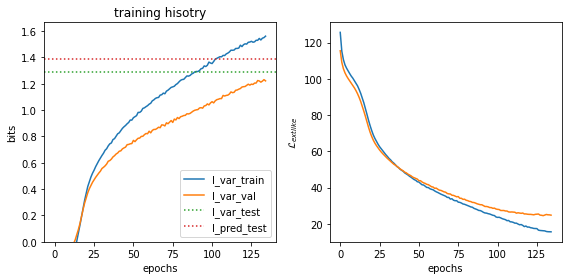

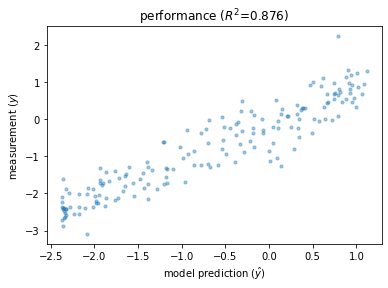

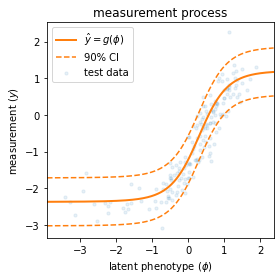

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.02 sec.
Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 120.6209 - I_var: -0.4047 - val_loss: 107.1555 - val_I_var: -0.3159
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 112.1720 - I_var: -0.2596 - val_loss: 103.4955 - val_I_var: -0.2200
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 108.5387 - I_var: -0.2108 - val_loss: 101.4536 - val_I_var: -0.1826
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 106.4300 - I_var: -0.1967 - val_loss: 99.8790 - val_I_var: -0.1650
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 104.7634 - I_var: -0.1869 - val_loss: 98.3617 - val_I_var: -0.1548
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 103.2019 - I_var: -0.1782 - val_loss: 96.5720 - val_I_var: -0.1439
Epoch 7/1000
9/9 [==============================

Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.6164 - I_var: 1.0254 - val_loss: 41.3256 - val_I_var: 0.9481
Epoch 61/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.3663 - I_var: 1.0432 - val_loss: 40.9684 - val_I_var: 0.9503
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.7956 - I_var: 1.0518 - val_loss: 41.0434 - val_I_var: 0.9443
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.5474 - I_var: 1.0683 - val_loss: 40.1712 - val_I_var: 0.9631
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.0905 - I_var: 1.0786 - val_loss: 40.3715 - val_I_var: 0.9550
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 35.8155 - I_var: 1.0885 - val_loss: 39.8943 - val_I_var: 0.9639
Epoch 66/1000
9/9 [==============================] - 0s 6ms/step - loss: 35.0295 - I_var: 1.0890 - val_loss: 39.1459 - val_I_var: 0.9691
Epoch 67/1000
9/9 [======================

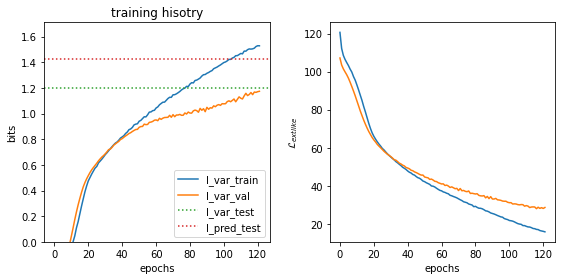

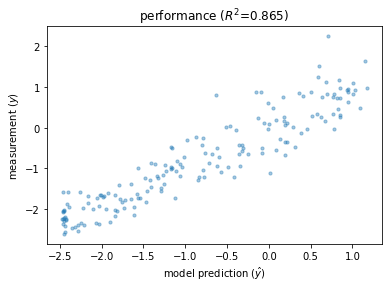

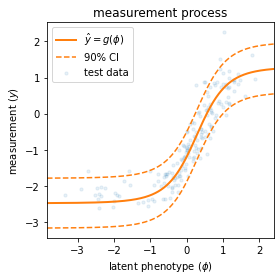

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0198 sec.
Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 144.3679 - I_var: -0.1021 - val_loss: 132.6217 - val_I_var: -0.0476
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 138.2168 - I_var: -0.0650 - val_loss: 127.0286 - val_I_var: -0.0081
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 131.8924 - I_var: -0.0298 - val_loss: 121.6450 - val_I_var: 0.0539
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 126.4237 - I_var: 0.0183 - val_loss: 116.7634 - val_I_var: 0.1005
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 120.4894 - I_var: 0.0580 - val_loss: 112.2203 - val_I_var: 0.1523
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 115.4168 - I_var: 0.1037 - val_loss: 107.7980 - val_I_var: 0.1940
Epoch 7/1000
9/9 [==============================] 

Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 38.7857 - I_var: 1.0943 - val_loss: 40.7513 - val_I_var: 0.9838
Epoch 61/1000
9/9 [==============================] - 0s 6ms/step - loss: 38.3557 - I_var: 1.0994 - val_loss: 40.2831 - val_I_var: 0.9886
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.8492 - I_var: 1.1094 - val_loss: 40.1336 - val_I_var: 0.9964
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.4434 - I_var: 1.1208 - val_loss: 39.5578 - val_I_var: 1.0084
Epoch 64/1000
9/9 [==============================] - 0s 7ms/step - loss: 37.1663 - I_var: 1.1317 - val_loss: 39.1885 - val_I_var: 1.0139
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.6558 - I_var: 1.1342 - val_loss: 38.9162 - val_I_var: 1.0189
Epoch 66/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.4032 - I_var: 1.1559 - val_loss: 38.8972 - val_I_var: 1.0330
Epoch 67/1000
9/9 [======================

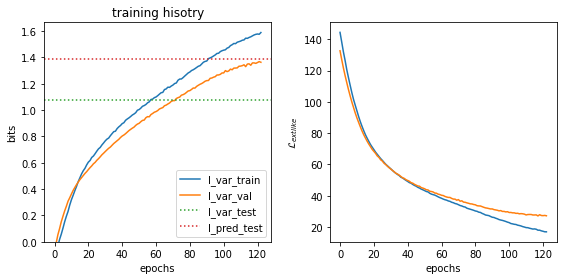

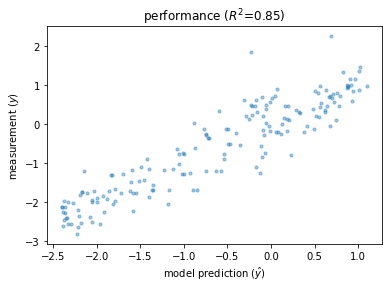

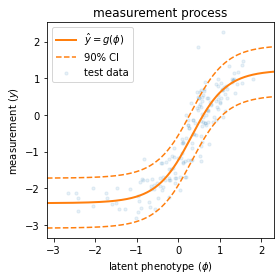

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0183 sec.
Epoch 1/1000
9/9 [==============================] - 0s 22ms/step - loss: 167.8310 - I_var: -0.6066 - val_loss: 152.7446 - val_I_var: -0.3955
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 152.5964 - I_var: -0.3835 - val_loss: 142.7598 - val_I_var: -0.2873
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 143.9064 - I_var: -0.2829 - val_loss: 136.1398 - val_I_var: -0.2400
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 137.8267 - I_var: -0.2335 - val_loss: 131.1162 - val_I_var: -0.2169
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 132.7386 - I_var: -0.2184 - val_loss: 126.9158 - val_I_var: -0.2025
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 128.9351 - I_var: -0.1945 - val_loss: 123.2287 - val_I_var: -0.1917
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.8187 - I_var: 1.5504 - val_loss: 24.9936 - val_I_var: 1.1271
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.7507 - I_var: 1.5538 - val_loss: 24.7725 - val_I_var: 1.1279
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.1634 - I_var: 1.5557 - val_loss: 24.4714 - val_I_var: 1.1376
Epoch 122/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.1777 - I_var: 1.5598 - val_loss: 24.1315 - val_I_var: 1.1386
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 17.7625 - I_var: 1.5581 - val_loss: 24.2667 - val_I_var: 1.1164
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 17.9306 - I_var: 1.5707 - val_loss: 24.4165 - val_I_var: 1.1122
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 17.5189 - I_var: 1.5724 - val_loss: 24.3015 - val_I_var: 1.1217
Epoch 126/1000
9/9 [==============

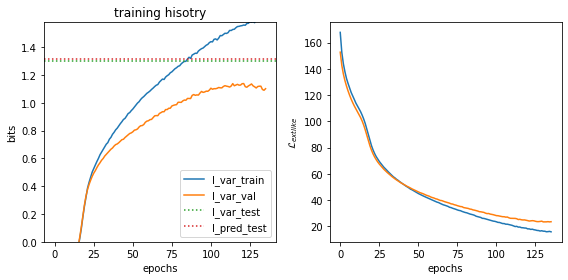

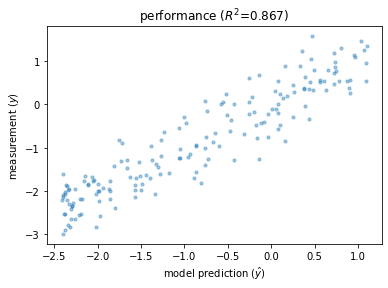

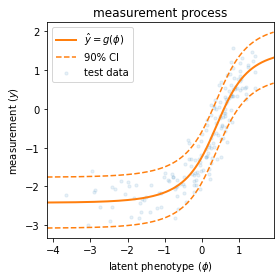

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0196 sec.
Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 189.3970 - I_var: -0.2414 - val_loss: 177.3521 - val_I_var: -0.0392
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 176.6071 - I_var: -0.1355 - val_loss: 167.9416 - val_I_var: 0.0074
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 168.0217 - I_var: -0.1143 - val_loss: 160.2018 - val_I_var: 0.0259
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 160.4112 - I_var: -0.0899 - val_loss: 152.7441 - val_I_var: 0.0458
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 152.7768 - I_var: -0.0598 - val_loss: 145.3039 - val_I_var: 0.0740
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 145.6417 - I_var: -0.0128 - val_loss: 137.9437 - val_I_var: 0.1122
Epoch 7/1000
9/9 [==============================

Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 38.4680 - I_var: 1.1297 - val_loss: 44.4104 - val_I_var: 0.8664
Epoch 61/1000
9/9 [==============================] - 0s 7ms/step - loss: 38.4058 - I_var: 1.1458 - val_loss: 44.0459 - val_I_var: 0.8641
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.7862 - I_var: 1.1523 - val_loss: 43.6078 - val_I_var: 0.8753
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 37.0183 - I_var: 1.1559 - val_loss: 43.1569 - val_I_var: 0.8620
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 36.7786 - I_var: 1.1706 - val_loss: 42.9826 - val_I_var: 0.8830
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 35.8826 - I_var: 1.1610 - val_loss: 42.9711 - val_I_var: 0.8781
Epoch 66/1000
9/9 [==============================] - 0s 6ms/step - loss: 35.7630 - I_var: 1.1846 - val_loss: 42.7854 - val_I_var: 0.8888
Epoch 67/1000
9/9 [======================

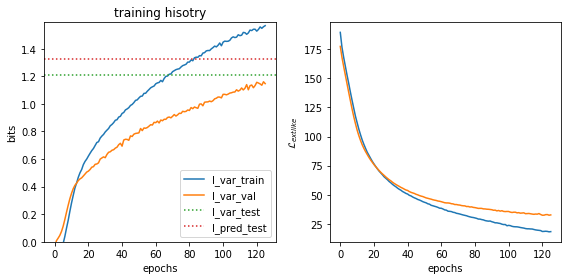

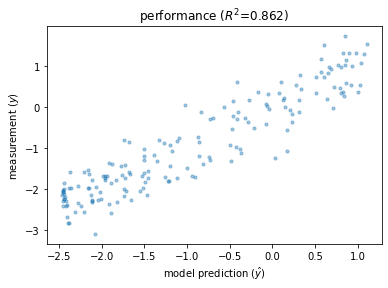

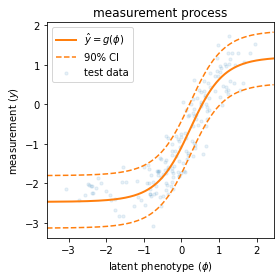

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000
9/9 [==============================] - 0s 23ms/step - loss: 200.4101 - I_var: -0.5458 - val_loss: 176.7829 - val_I_var: -0.4277
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 182.5475 - I_var: -0.3358 - val_loss: 165.9433 - val_I_var: -0.2855
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 170.6890 - I_var: -0.2363 - val_loss: 157.6676 - val_I_var: -0.2085
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 161.8245 - I_var: -0.1854 - val_loss: 150.8804 - val_I_var: -0.1679
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 154.6645 - I_var: -0.1611 - val_loss: 144.9344 - val_I_var: -0.1456
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 148.8430 - I_var: -0.1392 - val_loss: 139.5791 - val_I_var: -0.1298
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.8040 - I_var: 1.4848 - val_loss: 24.4278 - val_I_var: 1.4827
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.2924 - I_var: 1.4882 - val_loss: 23.9210 - val_I_var: 1.4916
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.2873 - I_var: 1.5041 - val_loss: 23.6582 - val_I_var: 1.4953
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.1228 - I_var: 1.4958 - val_loss: 23.3102 - val_I_var: 1.5084
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.5737 - I_var: 1.5024 - val_loss: 23.6180 - val_I_var: 1.5007
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.6216 - I_var: 1.5145 - val_loss: 23.1506 - val_I_var: 1.5093
Epoch 125/1000
9/9 [==============================] - 0s 7ms/step - loss: 20.4857 - I_var: 1.5122 - val_loss: 23.1832 - val_I_var: 1.5086
Epoch 126/1000
9/9 [==============

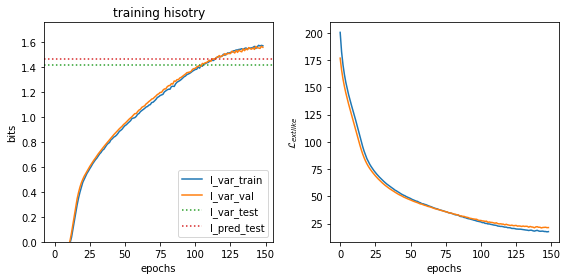

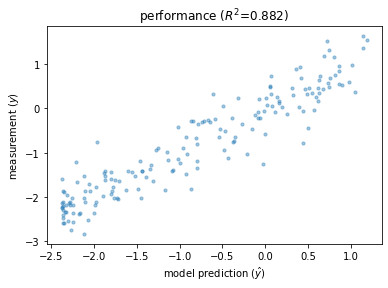

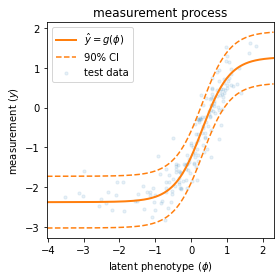

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0189 sec.
Epoch 1/1000
9/9 [==============================] - 0s 22ms/step - loss: 247.8286 - I_var: -0.3766 - val_loss: 229.1941 - val_I_var: -0.5041
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 227.8465 - I_var: -0.2333 - val_loss: 214.7197 - val_I_var: -0.3954
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 214.0912 - I_var: -0.1745 - val_loss: 202.8339 - val_I_var: -0.3510
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 202.4514 - I_var: -0.1597 - val_loss: 192.3135 - val_I_var: -0.3264
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 192.1603 - I_var: -0.1498 - val_loss: 182.6549 - val_I_var: -0.3066
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 182.5227 - I_var: -0.1363 - val_loss: 173.0559 - val_I_var: -0.2758
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.7956 - I_var: 1.4953 - val_loss: 20.5781 - val_I_var: 1.5181
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.9768 - I_var: 1.4856 - val_loss: 20.1602 - val_I_var: 1.5091
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.2205 - I_var: 1.4964 - val_loss: 20.2437 - val_I_var: 1.5230
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.1491 - I_var: 1.4918 - val_loss: 20.4313 - val_I_var: 1.5133
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.7558 - I_var: 1.5030 - val_loss: 20.0014 - val_I_var: 1.5354
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.6058 - I_var: 1.5050 - val_loss: 19.8995 - val_I_var: 1.5292
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.7812 - I_var: 1.5094 - val_loss: 19.9396 - val_I_var: 1.5300
Epoch 126/1000
9/9 [==============

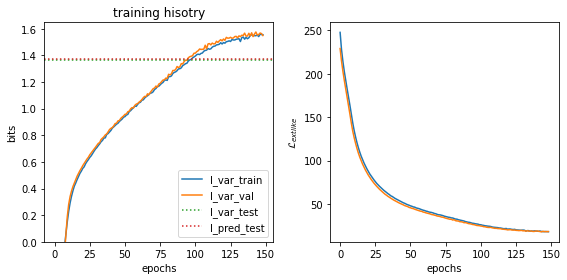

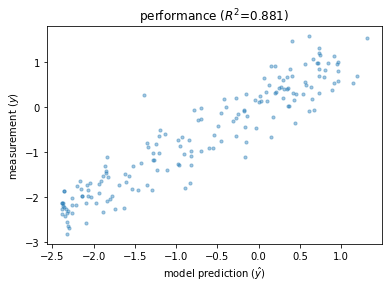

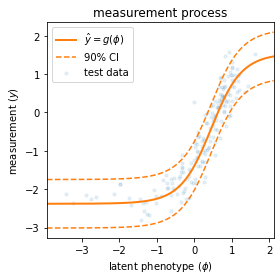

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0184 sec.
Epoch 1/1000
9/9 [==============================] - 0s 24ms/step - loss: 258.5809 - I_var: -0.5545 - val_loss: 238.5279 - val_I_var: -0.4587
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 235.0067 - I_var: -0.3401 - val_loss: 220.4481 - val_I_var: -0.2904
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 218.2873 - I_var: -0.2287 - val_loss: 206.5076 - val_I_var: -0.2089
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 205.0557 - I_var: -0.1872 - val_loss: 194.9663 - val_I_var: -0.1662
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 194.3639 - I_var: -0.1590 - val_loss: 185.0486 - val_I_var: -0.1437
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 184.7206 - I_var: -0.1541 - val_loss: 176.2966 - val_I_var: -0.1309
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 7ms/step - loss: 19.7932 - I_var: 1.5612 - val_loss: 28.0045 - val_I_var: 1.4621
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.6095 - I_var: 1.5660 - val_loss: 27.5902 - val_I_var: 1.4580
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.3480 - I_var: 1.5546 - val_loss: 27.6562 - val_I_var: 1.4763
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.1985 - I_var: 1.5704 - val_loss: 27.7620 - val_I_var: 1.4816
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.9264 - I_var: 1.5648 - val_loss: 28.8094 - val_I_var: 1.4478
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.4870 - I_var: 1.5694 - val_loss: 27.4472 - val_I_var: 1.4798
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.5405 - I_var: 1.5849 - val_loss: 27.8051 - val_I_var: 1.4751
Epoch 126/1000
9/9 [==============

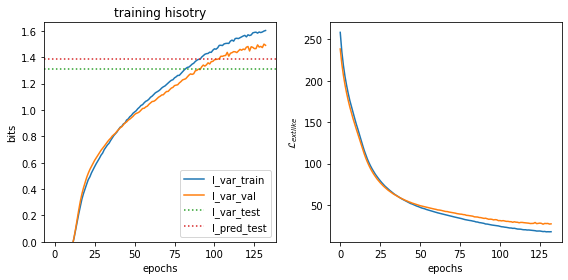

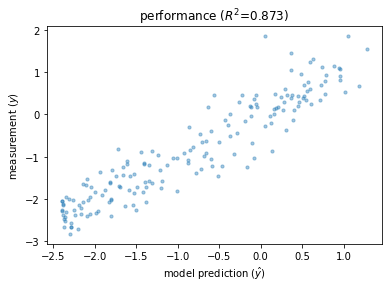

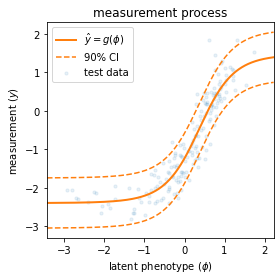

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 289.9033 - I_var: -0.4191 - val_loss: 275.4460 - val_I_var: -0.3298
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 265.2455 - I_var: -0.2313 - val_loss: 254.4754 - val_I_var: -0.2091
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 247.1227 - I_var: -0.1560 - val_loss: 238.3659 - val_I_var: -0.1675
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 232.2197 - I_var: -0.1431 - val_loss: 224.7126 - val_I_var: -0.1508
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 219.7406 - I_var: -0.1196 - val_loss: 212.6909 - val_I_var: -0.1424
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 208.2346 - I_var: -0.1181 - val_loss: 201.9617 - val_I_var: -0.1374
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.2730 - I_var: 1.5930 - val_loss: 29.3982 - val_I_var: 1.4418
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.8966 - I_var: 1.5888 - val_loss: 29.3477 - val_I_var: 1.4449
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.5374 - I_var: 1.5945 - val_loss: 29.0235 - val_I_var: 1.4505
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.6516 - I_var: 1.5953 - val_loss: 29.1305 - val_I_var: 1.4464
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.4973 - I_var: 1.6036 - val_loss: 29.1899 - val_I_var: 1.4579
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.8820 - I_var: 1.6043 - val_loss: 29.3955 - val_I_var: 1.4414
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.8774 - I_var: 1.6136 - val_loss: 28.7043 - val_I_var: 1.4537
Epoch 126/1000
9/9 [==============

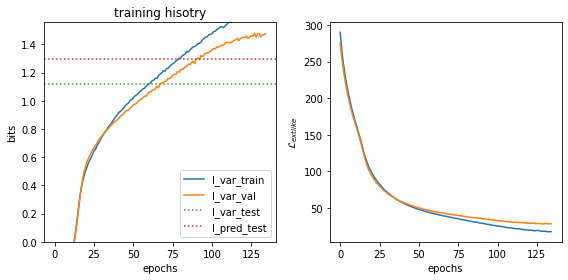

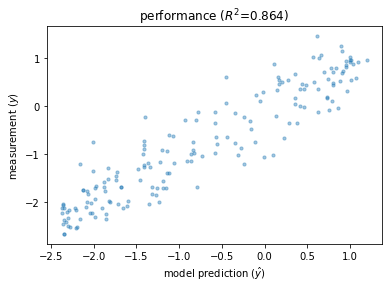

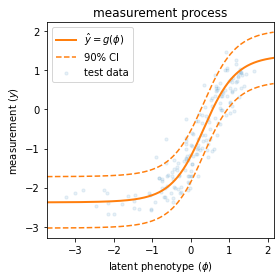

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0172 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 286.8448 - I_var: -0.5483 - val_loss: 261.7377 - val_I_var: -0.2588
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 261.9196 - I_var: -0.3378 - val_loss: 243.0808 - val_I_var: -0.1845
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 242.9723 - I_var: -0.2617 - val_loss: 227.9288 - val_I_var: -0.1569
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 228.2305 - I_var: -0.2184 - val_loss: 214.7677 - val_I_var: -0.1434
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 215.4664 - I_var: -0.1927 - val_loss: 203.1359 - val_I_var: -0.1362
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 203.9272 - I_var: -0.1884 - val_loss: 192.7643 - val_I_var: -0.1322
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.9873 - I_var: 1.5304 - val_loss: 30.1226 - val_I_var: 1.2709
Training time: 7.9 seconds
On test data:
I_var_test: 1.237 +- 0.127 bits
I_pred_test: 1.427 +- 0.047 bits


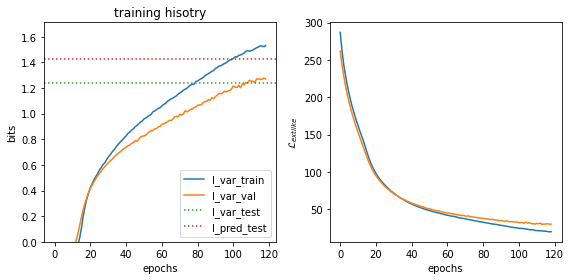

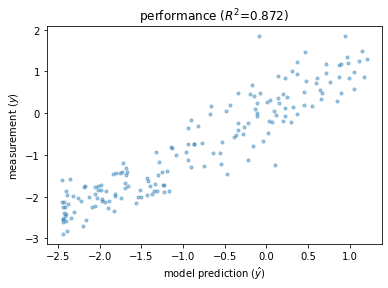

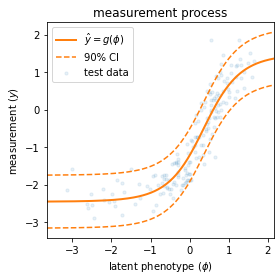

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0172 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 326.3213 - I_var: -0.3396 - val_loss: 310.5636 - val_I_var: -0.3205
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 299.9980 - I_var: -0.1838 - val_loss: 287.1593 - val_I_var: -0.2225
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 279.1195 - I_var: -0.1295 - val_loss: 267.9573 - val_I_var: -0.1790
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 261.7038 - I_var: -0.0966 - val_loss: 251.3757 - val_I_var: -0.1551
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 246.0593 - I_var: -0.0802 - val_loss: 236.6792 - val_I_var: -0.1378
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 231.6657 - I_var: -0.0668 - val_loss: 223.3753 - val_I_var: -0.1155
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.4347 - I_var: 1.5318 - val_loss: 25.8349 - val_I_var: 1.4137
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.1519 - I_var: 1.5419 - val_loss: 25.4933 - val_I_var: 1.4373
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.2550 - I_var: 1.5485 - val_loss: 25.4979 - val_I_var: 1.4225
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.8820 - I_var: 1.5408 - val_loss: 25.3498 - val_I_var: 1.4254
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.9389 - I_var: 1.5538 - val_loss: 25.3600 - val_I_var: 1.4359
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.7243 - I_var: 1.5469 - val_loss: 25.3658 - val_I_var: 1.4237
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.6074 - I_var: 1.5597 - val_loss: 25.4744 - val_I_var: 1.4478
Epoch 126/1000
9/9 [==============

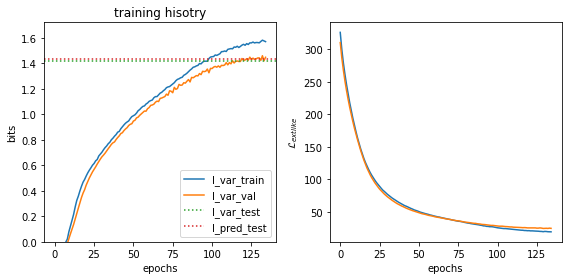

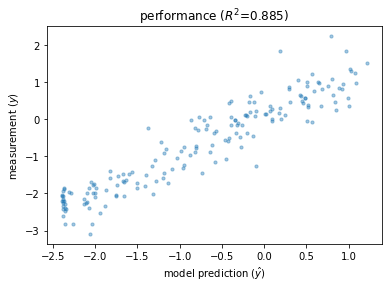

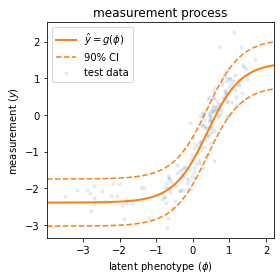

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 324.1534 - I_var: -0.3621 - val_loss: 303.1357 - val_I_var: -0.2560
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 294.7882 - I_var: -0.1354 - val_loss: 279.2769 - val_I_var: -0.0952
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 273.9918 - I_var: -0.0651 - val_loss: 260.4633 - val_I_var: -0.0287
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 256.4115 - I_var: -0.0369 - val_loss: 244.1850 - val_I_var: 0.0024
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 240.8723 - I_var: -0.0142 - val_loss: 229.2186 - val_I_var: 0.0266
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 226.4840 - I_var: 0.0162 - val_loss: 215.0394 - val_I_var: 0.0520
Epoch 7/1000
9/9 [=============================

Epoch 119/1000
9/9 [==============================] - 0s 7ms/step - loss: 19.7127 - I_var: 1.5937 - val_loss: 21.8366 - val_I_var: 1.4756
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.6099 - I_var: 1.5981 - val_loss: 22.0032 - val_I_var: 1.4803
Epoch 121/1000
9/9 [==============================] - 0s 7ms/step - loss: 19.1502 - I_var: 1.5841 - val_loss: 21.7217 - val_I_var: 1.4964
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.2850 - I_var: 1.5862 - val_loss: 21.5092 - val_I_var: 1.4757
Epoch 123/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.2547 - I_var: 1.5934 - val_loss: 21.4154 - val_I_var: 1.4970
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 19.3912 - I_var: 1.6121 - val_loss: 21.9883 - val_I_var: 1.4589
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 18.7853 - I_var: 1.6121 - val_loss: 21.4929 - val_I_var: 1.5003
Epoch 126/1000
9/9 [==============

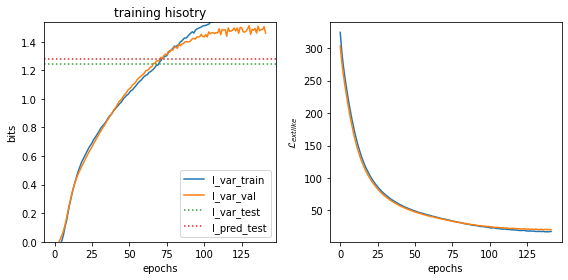

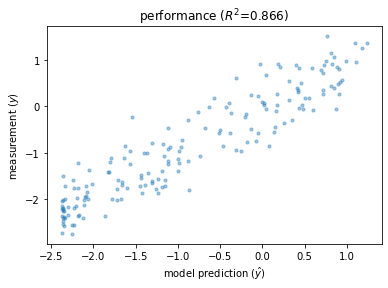

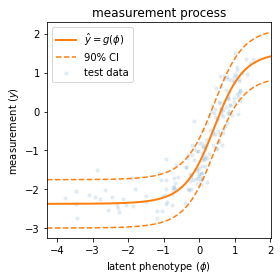

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 362.2930 - I_var: -0.2639 - val_loss: 342.4723 - val_I_var: -0.1790
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 331.9173 - I_var: -0.1197 - val_loss: 314.9454 - val_I_var: -0.0749
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 307.8457 - I_var: -0.0668 - val_loss: 292.4130 - val_I_var: -0.0344
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 286.5305 - I_var: -0.0536 - val_loss: 272.7499 - val_I_var: -0.0101
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 267.4749 - I_var: -0.0192 - val_loss: 255.0836 - val_I_var: 0.0139
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 249.6729 - I_var: 0.0116 - val_loss: 239.0875 - val_I_var: 0.0397
Epoch 7/1000
9/9 [============================

9/9 [==============================] - 0s 6ms/step - loss: 21.2850 - I_var: 1.5440 - val_loss: 27.7330 - val_I_var: 1.5094
Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 21.1014 - I_var: 1.5458 - val_loss: 27.3846 - val_I_var: 1.5108
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 20.9068 - I_var: 1.5454 - val_loss: 27.5013 - val_I_var: 1.5119
Training time: 8.5 seconds
On test data:
I_var_test: 1.344 +- 0.128 bits
I_pred_test: 1.509 +- 0.056 bits


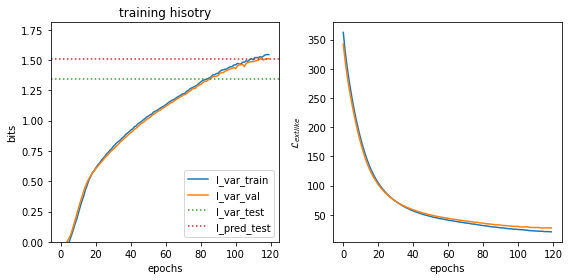

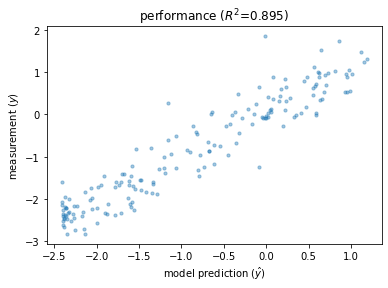

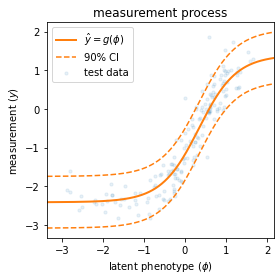

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.02 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 370.6534 - I_var: -0.2688 - val_loss: 353.2814 - val_I_var: -0.1862
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 340.0868 - I_var: -0.1389 - val_loss: 328.1195 - val_I_var: -0.1553
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 316.1773 - I_var: -0.0940 - val_loss: 306.5880 - val_I_var: -0.1482
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 295.3127 - I_var: -0.0775 - val_loss: 287.1735 - val_I_var: -0.1374
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 276.1297 - I_var: -0.0694 - val_loss: 268.9357 - val_I_var: -0.1054
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 259.0198 - I_var: -0.0282 - val_loss: 252.0569 - val_I_var: -0.0675
Epoch 7/1000
9/9 [===========================

Training time: 8.6 seconds
On test data:
I_var_test: 1.377 +- 0.107 bits
I_pred_test: 1.564 +- 0.063 bits


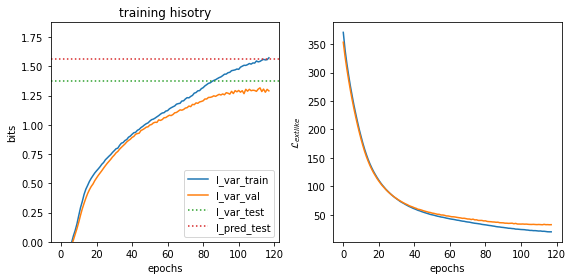

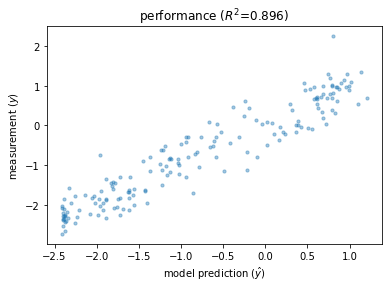

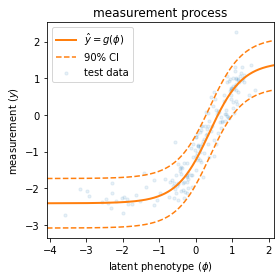

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0194 sec.
Epoch 1/1000
9/9 [==============================] - 0s 26ms/step - loss: 401.9792 - I_var: -0.3435 - val_loss: 379.6938 - val_I_var: -0.2187
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 369.7741 - I_var: -0.2221 - val_loss: 351.3709 - val_I_var: -0.1861
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 342.4388 - I_var: -0.1855 - val_loss: 326.5713 - val_I_var: -0.1686
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 318.7289 - I_var: -0.1539 - val_loss: 303.9404 - val_I_var: -0.1399
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 296.5932 - I_var: -0.1211 - val_loss: 282.6417 - val_I_var: -0.0857
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 275.7856 - I_var: -0.0703 - val_loss: 262.7018 - val_I_var: -0.0165
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 7ms/step - loss: 19.1402 - I_var: 1.5458 - val_loss: 33.9885 - val_I_var: 1.2008
Epoch 120/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.6137 - I_var: 1.5399 - val_loss: 34.3499 - val_I_var: 1.1899
Epoch 121/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.6016 - I_var: 1.5500 - val_loss: 34.3011 - val_I_var: 1.1865
Epoch 122/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.4235 - I_var: 1.5520 - val_loss: 33.9943 - val_I_var: 1.1882
Epoch 123/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.5684 - I_var: 1.5521 - val_loss: 33.6742 - val_I_var: 1.2080
Epoch 124/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.4257 - I_var: 1.5520 - val_loss: 34.3582 - val_I_var: 1.1725
Epoch 125/1000
9/9 [==============================] - 0s 7ms/step - loss: 18.3062 - I_var: 1.5584 - val_loss: 34.6526 - val_I_var: 1.1868
Epoch 126/1000
9/9 [==============

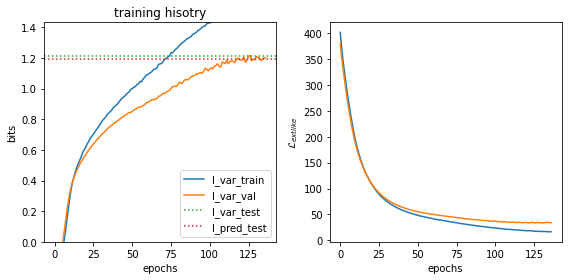

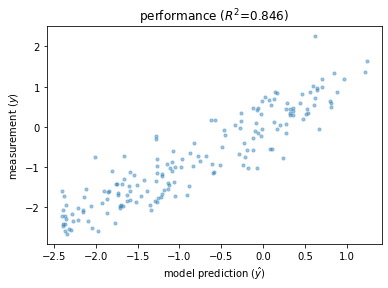

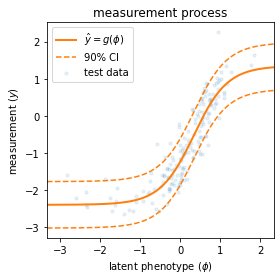

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0185 sec.
Epoch 1/1000
9/9 [==============================] - 0s 22ms/step - loss: 433.9102 - I_var: -0.6289 - val_loss: 410.5406 - val_I_var: -0.6812
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 394.4309 - I_var: -0.3914 - val_loss: 376.1744 - val_I_var: -0.4965
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 363.9408 - I_var: -0.2902 - val_loss: 348.1287 - val_I_var: -0.4075
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 338.2642 - I_var: -0.2391 - val_loss: 323.9784 - val_I_var: -0.3578
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 316.0373 - I_var: -0.2054 - val_loss: 302.9064 - val_I_var: -0.3318
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 296.1369 - I_var: -0.1951 - val_loss: 284.2601 - val_I_var: -0.3183
Epoch 7/1000
9/9 [=========================

Epoch 119/1000
9/9 [==============================] - 0s 6ms/step - loss: 23.4277 - I_var: 1.4763 - val_loss: 34.7005 - val_I_var: 1.1431
Epoch 120/1000
9/9 [==============================] - 0s 6ms/step - loss: 23.3642 - I_var: 1.4912 - val_loss: 34.7291 - val_I_var: 1.1371
Epoch 121/1000
9/9 [==============================] - 0s 6ms/step - loss: 23.1473 - I_var: 1.4990 - val_loss: 34.6327 - val_I_var: 1.1443
Epoch 122/1000
9/9 [==============================] - 0s 6ms/step - loss: 22.8497 - I_var: 1.5008 - val_loss: 34.1174 - val_I_var: 1.1492
Epoch 123/1000
9/9 [==============================] - 0s 7ms/step - loss: 22.5839 - I_var: 1.5107 - val_loss: 34.0677 - val_I_var: 1.1573
Epoch 124/1000
9/9 [==============================] - 0s 6ms/step - loss: 22.4566 - I_var: 1.5159 - val_loss: 34.0533 - val_I_var: 1.1449
Epoch 125/1000
9/9 [==============================] - 0s 6ms/step - loss: 22.0186 - I_var: 1.5181 - val_loss: 34.5883 - val_I_var: 1.1424
Epoch 126/1000
9/9 [==============

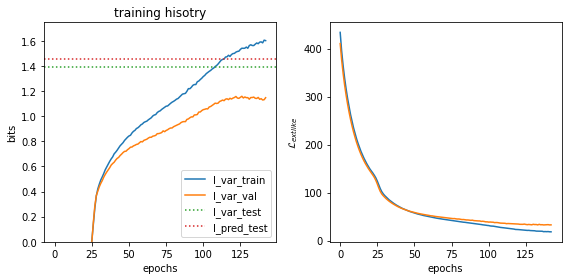

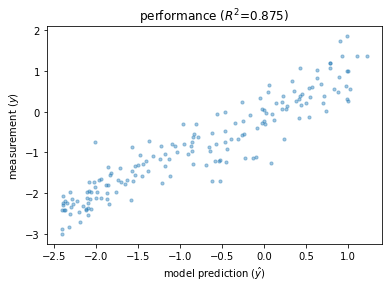

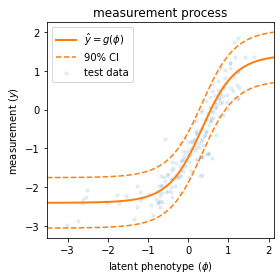

[[0.12077166]
 [0.00343872]
 [0.19919198]
 [0.51951037]
 [0.03829279]
 [0.37948918]
 [0.39974284]
 [0.11249287]]


In [12]:
#Find the best regularization for additive fitness(regularization)
reg_ls=[1e-1,3e-1,5e-1,8e-1,1,1.2,1.5,1.7]
add=np.zeros((8,1))
R2=np.zeros((19,2))

for reg in reg_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89') 
        model = Train_model(train_set,test_set,reg,0.001,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        theta_lc=theta['theta_lc']
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    add_index = reg_ls.index(reg)
    add[add_index,0]=R
print(add)    
 

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0199 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 257.3894 - I_var: -0.4629 - val_loss: 237.4547 - val_I_var: -0.3373
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 236.6789 - I_var: -0.3005 - val_loss: 221.8449 - val_I_var: -0.2398
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 221.9529 - I_var: -0.2301 - val_loss: 209.0319 - val_I_var: -0.1922
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 209.9388 - I_var: -0.1901 - val_loss: 198.0694 - val_I_var: -0.1692
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 199.1838 - I_var: -0.1834 - val_loss: 188.3791 - val_I_var: -0.1555
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 189.6913 - I_var: -0.1780 - val_loss: 179.7457 - val_I_var: -0.1476
Epoch 7/1000
9/9 [=========================

9/9 [==============================] - 0s 6ms/step - loss: 48.1333 - I_var: 0.9368 - val_loss: 52.7344 - val_I_var: 0.8493
Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 47.7812 - I_var: 0.9493 - val_loss: 52.5380 - val_I_var: 0.8463
Epoch 61/1000
9/9 [==============================] - 0s 6ms/step - loss: 47.5590 - I_var: 0.9628 - val_loss: 52.7051 - val_I_var: 0.8464
Epoch 62/1000
9/9 [==============================] - 0s 6ms/step - loss: 46.9775 - I_var: 0.9646 - val_loss: 51.9599 - val_I_var: 0.8561
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 46.5751 - I_var: 0.9688 - val_loss: 51.5717 - val_I_var: 0.8661
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 46.2858 - I_var: 0.9793 - val_loss: 51.6132 - val_I_var: 0.8652
Epoch 65/1000
9/9 [==============================] - 0s 5ms/step - loss: 45.9374 - I_var: 0.9836 - val_loss: 51.3633 - val_I_var: 0.8632
Epoch 66/1000
9/9 [==============================] - 0s

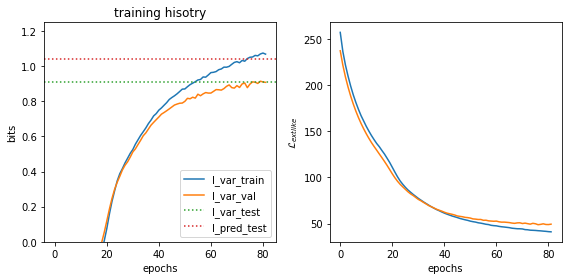

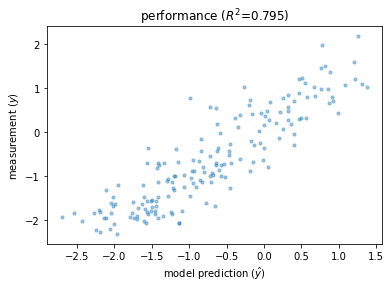

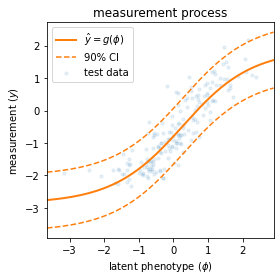

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0151 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 274.2310 - I_var: -0.7180 - val_loss: 245.8212 - val_I_var: -0.1708
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 246.0041 - I_var: -0.3893 - val_loss: 224.4734 - val_I_var: -0.0150
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 226.7917 - I_var: -0.2331 - val_loss: 208.9738 - val_I_var: 0.0462
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 212.9211 - I_var: -0.1603 - val_loss: 196.7790 - val_I_var: 0.0677
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 201.6793 - I_var: -0.1334 - val_loss: 186.5628 - val_I_var: 0.0739
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 192.1418 - I_var: -0.1158 - val_loss: 177.6938 - val_I_var: 0.0755
Epoch 7/1000
9/9 [=============================

9/9 [==============================] - 0s 6ms/step - loss: 50.5602 - I_var: 0.9670 - val_loss: 52.4380 - val_I_var: 0.9279
Epoch 60/1000
9/9 [==============================] - 0s 6ms/step - loss: 49.8213 - I_var: 0.9691 - val_loss: 51.7967 - val_I_var: 0.9397
Epoch 61/1000
9/9 [==============================] - 0s 6ms/step - loss: 49.5621 - I_var: 0.9858 - val_loss: 51.5317 - val_I_var: 0.9428
Epoch 62/1000
9/9 [==============================] - 0s 5ms/step - loss: 49.1613 - I_var: 0.9878 - val_loss: 51.1677 - val_I_var: 0.9533
Epoch 63/1000
9/9 [==============================] - 0s 6ms/step - loss: 48.5924 - I_var: 0.9907 - val_loss: 50.9310 - val_I_var: 0.9572
Epoch 64/1000
9/9 [==============================] - 0s 6ms/step - loss: 48.1090 - I_var: 0.9983 - val_loss: 50.3113 - val_I_var: 0.9723
Epoch 65/1000
9/9 [==============================] - 0s 6ms/step - loss: 47.8503 - I_var: 1.0149 - val_loss: 50.6905 - val_I_var: 0.9572
Epoch 66/1000
9/9 [==============================] - 0s

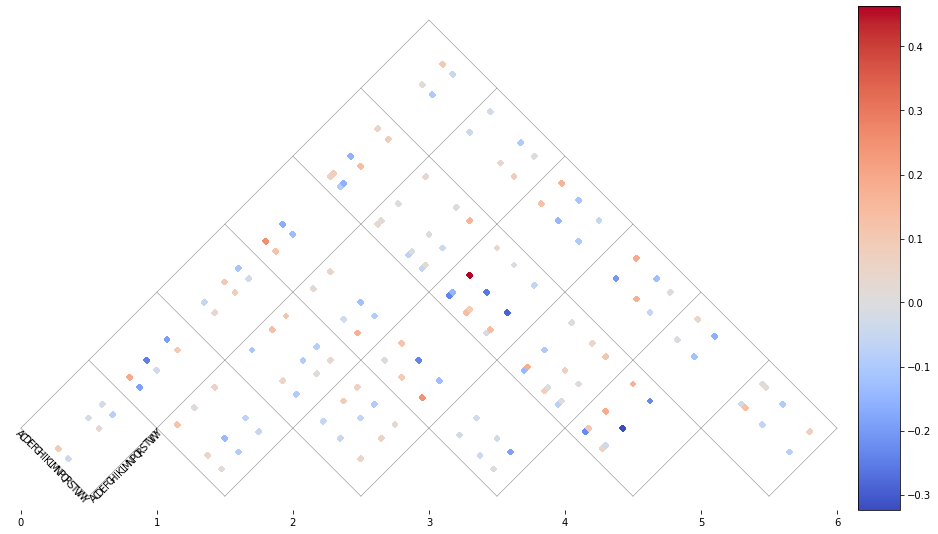

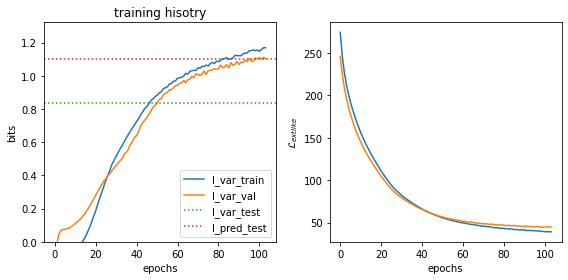

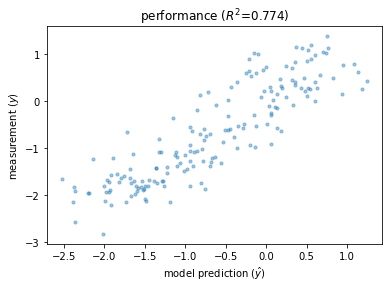

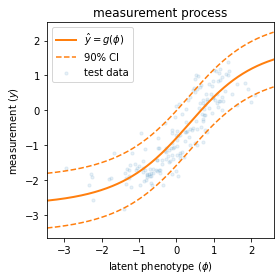

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0156 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 224.7171 - I_var: -0.2851 - val_loss: 182.6829 - val_I_var: -0.1001
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 171.1370 - I_var: -0.1718 - val_loss: 145.5088 - val_I_var: -0.1082
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 140.9163 - I_var: -0.1389 - val_loss: 121.4939 - val_I_var: -0.0376
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 115.2943 - I_var: 0.0348 - val_loss: 98.6363 - val_I_var: 0.1394
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 95.8637 - I_var: 0.2499 - val_loss: 86.4214 - val_I_var: 0.2687
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 83.2084 - I_var: 0.3903 - val_loss: 75.2487 - val_I_var: 0.4195
Epoch 7/1000
9/9 [==============================] - 0s

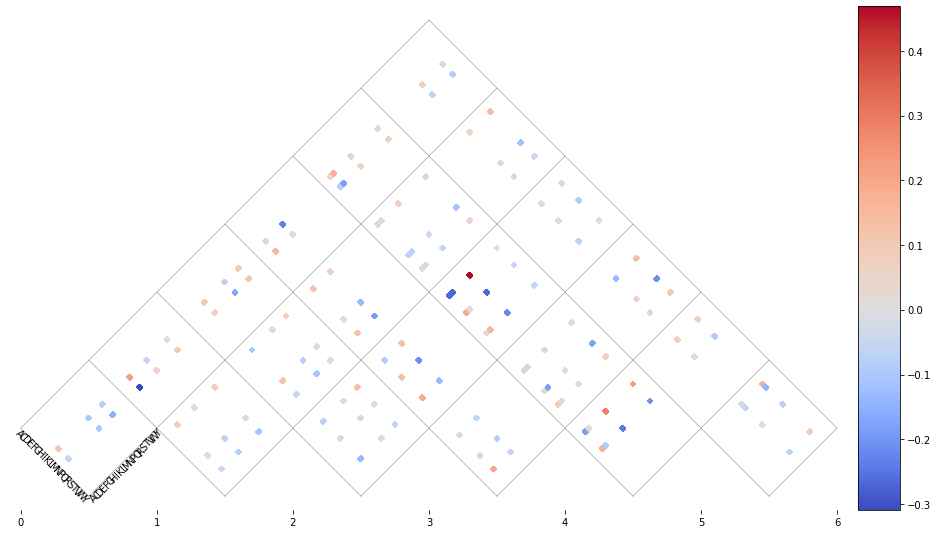

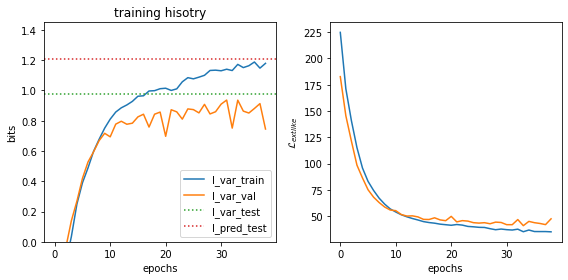

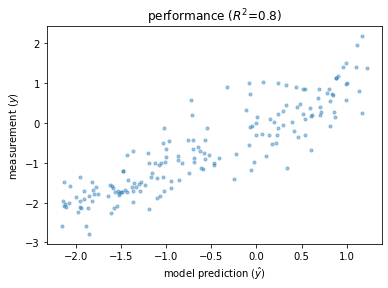

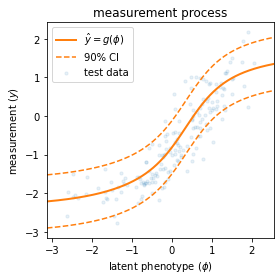

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0152 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 218.4919 - I_var: -0.0860 - val_loss: 179.9973 - val_I_var: 0.1110
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 164.1581 - I_var: 0.0456 - val_loss: 138.3844 - val_I_var: 0.1078
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 128.7644 - I_var: 0.1771 - val_loss: 110.1052 - val_I_var: 0.2381
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 104.6882 - I_var: 0.3196 - val_loss: 91.7644 - val_I_var: 0.3663
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.0503 - I_var: 0.4340 - val_loss: 81.2551 - val_I_var: 0.3969
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 78.6023 - I_var: 0.5227 - val_loss: 72.9221 - val_I_var: 0.5129
Epoch 7/1000
9/9 [==============================] - 0s 7ms/

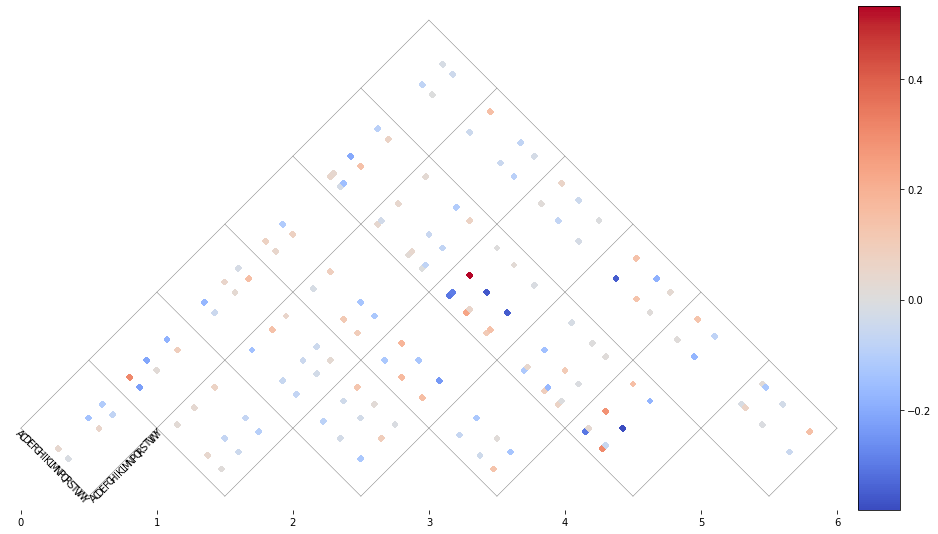

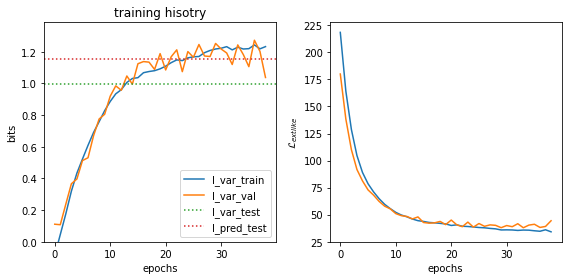

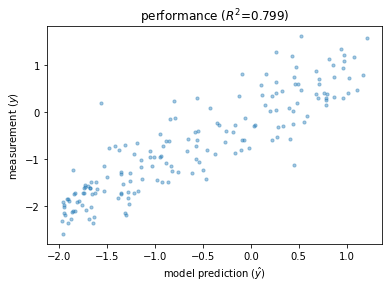

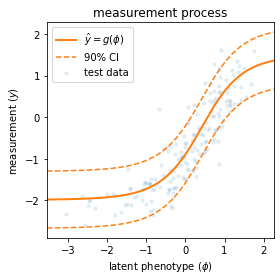

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 199.2834 - I_var: -0.2257 - val_loss: 148.9860 - val_I_var: -0.2361
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 126.1842 - I_var: -0.0292 - val_loss: 103.5020 - val_I_var: 0.0100
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.5343 - I_var: 0.2792 - val_loss: 81.2668 - val_I_var: 0.2957
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 74.2452 - I_var: 0.4275 - val_loss: 71.4719 - val_I_var: 0.4690
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 64.9565 - I_var: 0.5585 - val_loss: 62.0659 - val_I_var: 0.6285
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 57.0682 - I_var: 0.6997 - val_loss: 56.5115 - val_I_var: 0.7247
Epoch 7/1000
9/9 [==============================] - 0s 6ms/s

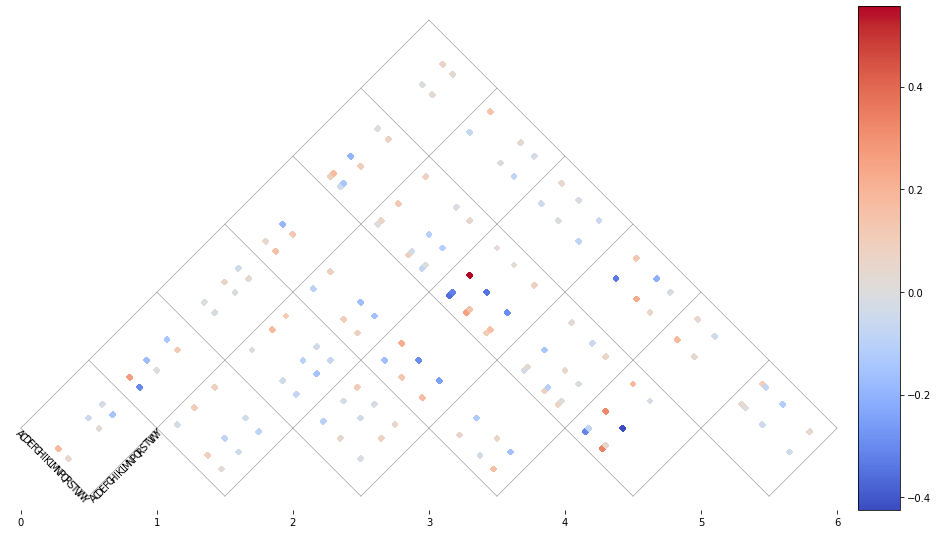

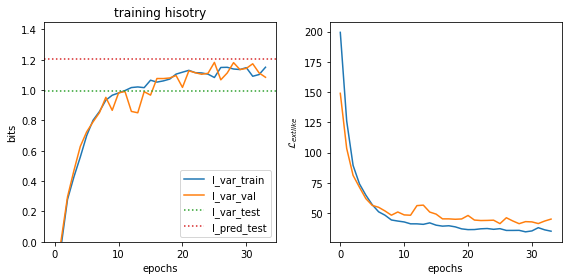

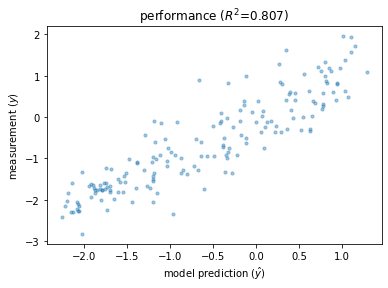

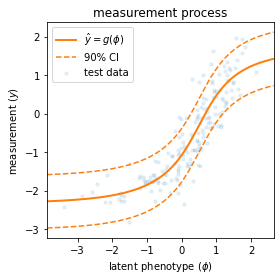

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0157 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 200.3107 - I_var: -0.2063 - val_loss: 150.0648 - val_I_var: -0.1784
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 129.9890 - I_var: -0.0878 - val_loss: 113.3972 - val_I_var: -0.1528
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 102.9313 - I_var: -0.0076 - val_loss: 90.5775 - val_I_var: 0.1273
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 80.8016 - I_var: 0.3126 - val_loss: 74.6671 - val_I_var: 0.3489
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 69.0060 - I_var: 0.5055 - val_loss: 65.4693 - val_I_var: 0.5288
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 59.3845 - I_var: 0.6933 - val_loss: 59.7968 - val_I_var: 0.6940
Epoch 7/1000
9/9 [==============================] - 0s 6m

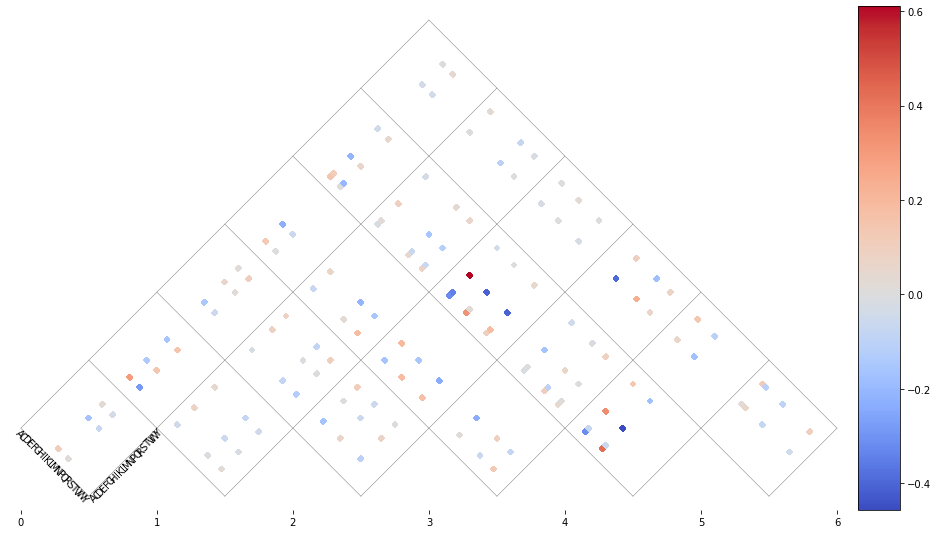

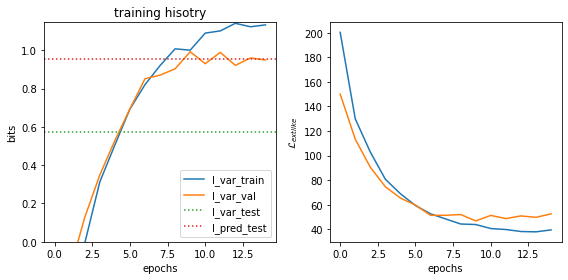

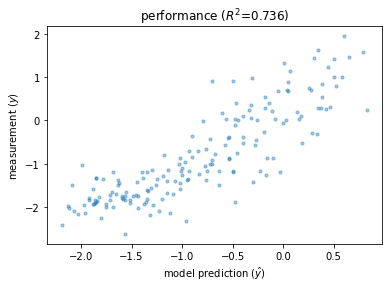

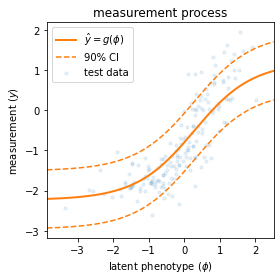

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0179 sec.
Epoch 1/1000
9/9 [==============================] - 0s 21ms/step - loss: 155.9024 - I_var: -0.0303 - val_loss: 85.9300 - val_I_var: 0.3967
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 85.3261 - I_var: 0.4018 - val_loss: 67.5288 - val_I_var: 0.6133
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 63.7965 - I_var: 0.7087 - val_loss: 48.9523 - val_I_var: 0.8583
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 52.2732 - I_var: 0.8840 - val_loss: 46.2098 - val_I_var: 0.9712
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 47.3528 - I_var: 0.9939 - val_loss: 45.3162 - val_I_var: 0.9013
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 47.0851 - I_var: 0.9970 - val_loss: 44.2110 - val_I_var: 0.9909
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step -

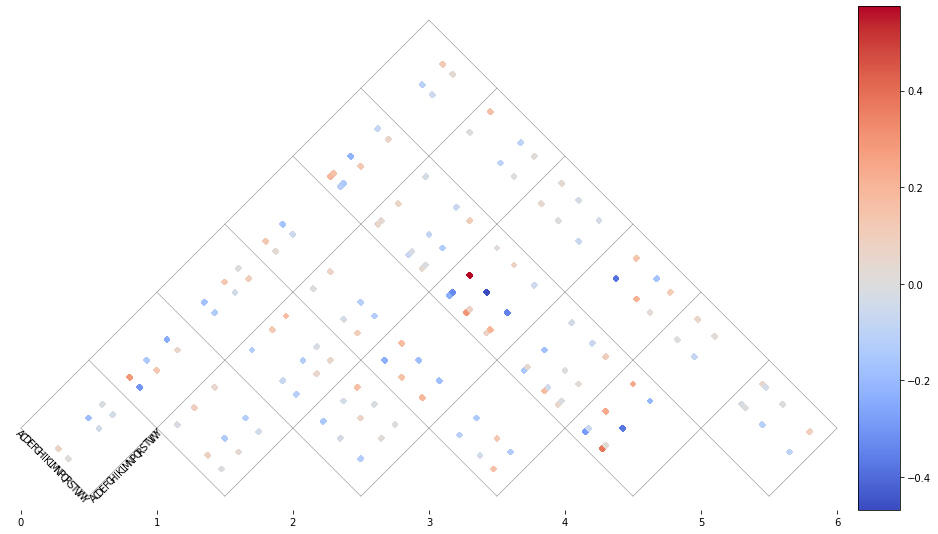

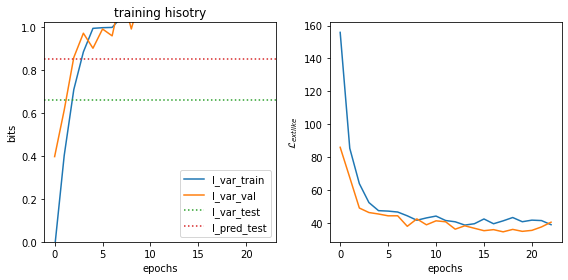

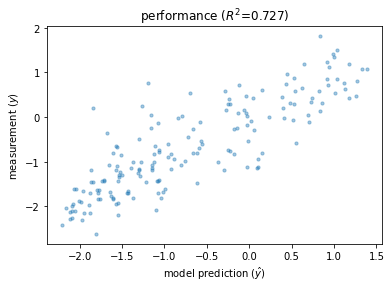

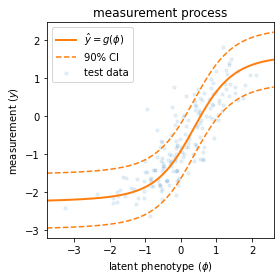

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0157 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 155.7081 - I_var: -0.1786 - val_loss: 99.6941 - val_I_var: 0.1089
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.3376 - I_var: 0.2272 - val_loss: 75.5095 - val_I_var: 0.4843
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 67.7176 - I_var: 0.5723 - val_loss: 57.0052 - val_I_var: 0.8037
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 53.3039 - I_var: 0.8201 - val_loss: 56.5454 - val_I_var: 0.8534
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 49.9220 - I_var: 0.8776 - val_loss: 51.3026 - val_I_var: 0.9762
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 51.0921 - I_var: 0.8578 - val_loss: 49.5530 - val_I_var: 1.0324
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

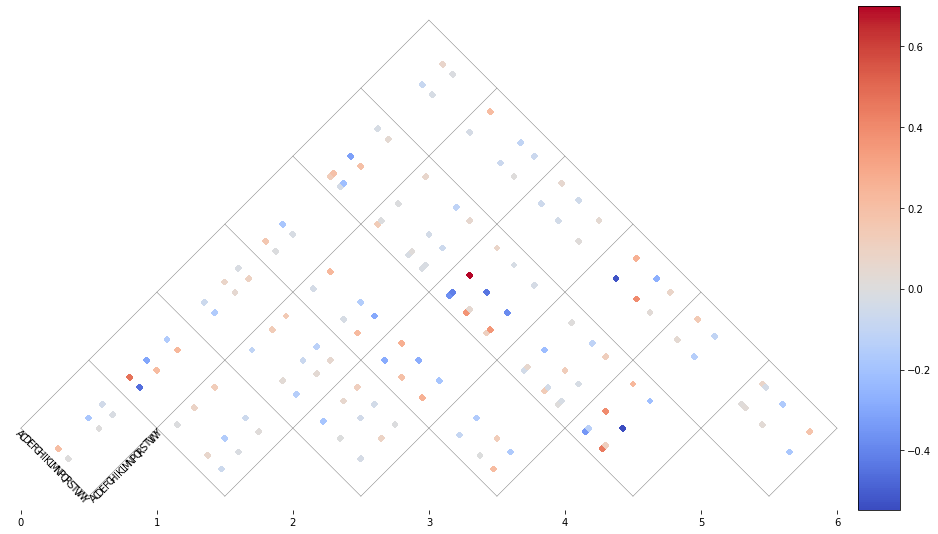

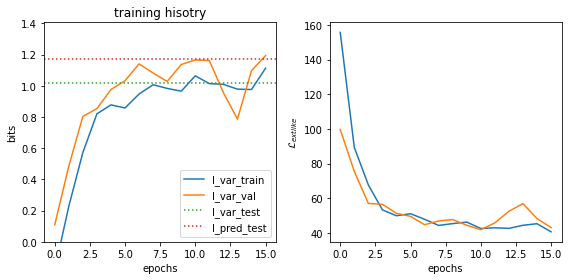

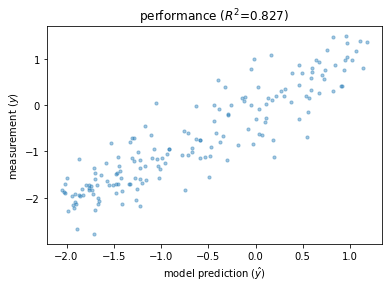

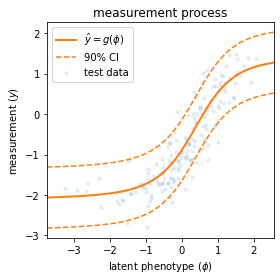

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0163 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 136.2310 - I_var: -0.0250 - val_loss: 91.8334 - val_I_var: 0.3438
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.6650 - I_var: 0.4428 - val_loss: 70.2373 - val_I_var: 0.5790
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 62.0375 - I_var: 0.7099 - val_loss: 47.6325 - val_I_var: 0.9986
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 60.5945 - I_var: 0.6879 - val_loss: 48.3195 - val_I_var: 0.9745
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 58.3870 - I_var: 0.7179 - val_loss: 48.2049 - val_I_var: 0.9757
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 53.2237 - I_var: 0.8175 - val_loss: 43.5751 - val_I_var: 1.0774
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

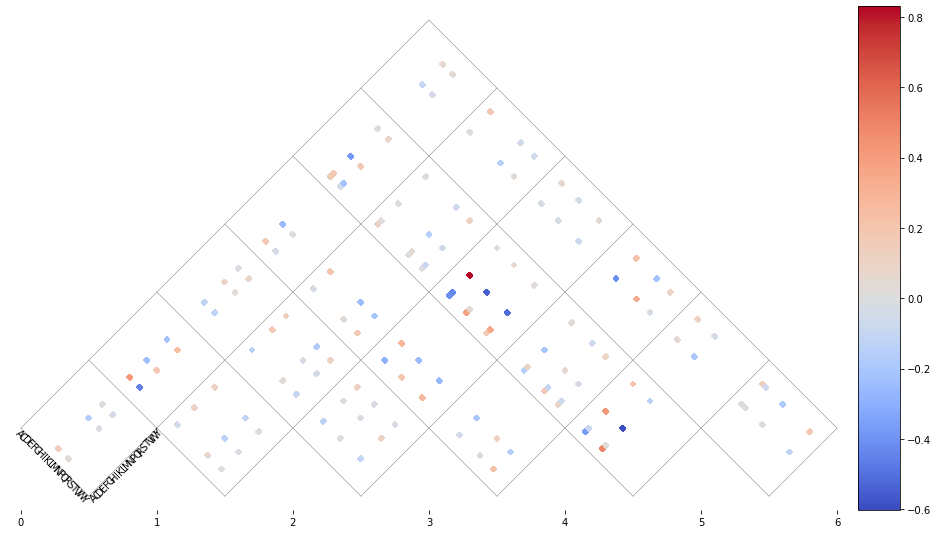

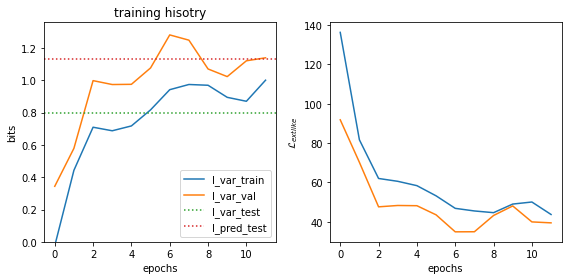

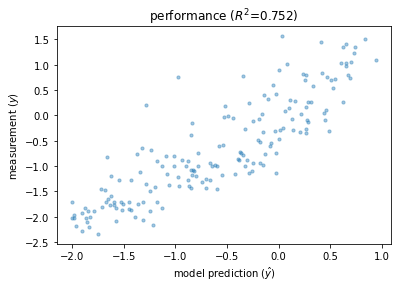

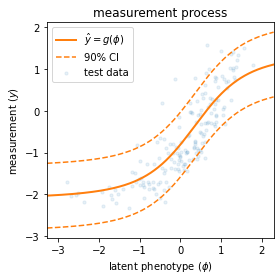

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.015 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 146.2137 - I_var: -0.1515 - val_loss: 97.5454 - val_I_var: 0.2021
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 89.0737 - I_var: 0.2661 - val_loss: 64.5367 - val_I_var: 0.5830
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 64.1657 - I_var: 0.6071 - val_loss: 50.3631 - val_I_var: 0.8407
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 55.9096 - I_var: 0.7570 - val_loss: 56.3585 - val_I_var: 0.8169
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 51.2566 - I_var: 0.8517 - val_loss: 47.6412 - val_I_var: 0.9228
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 49.2069 - I_var: 0.9029 - val_loss: 45.5179 - val_I_var: 0.9628
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - 

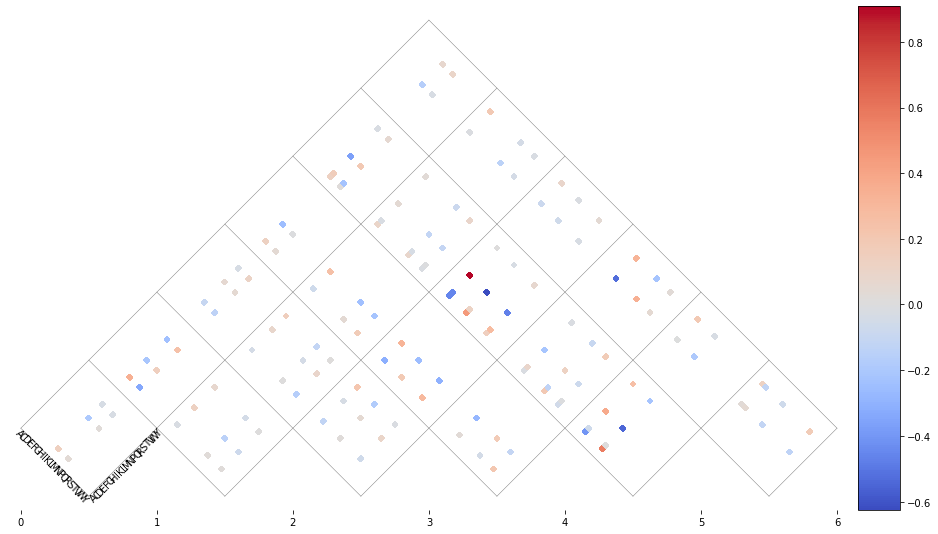

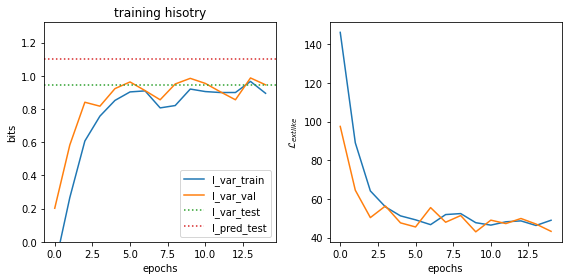

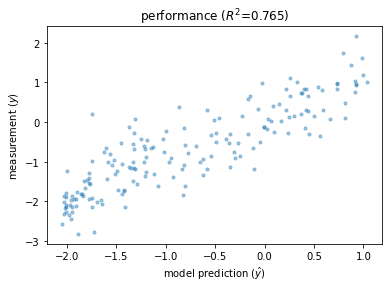

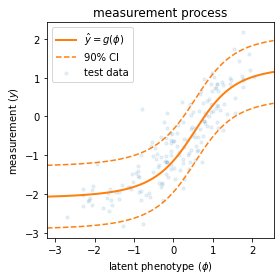

[[0.13253875]
 [0.04773169]
 [0.46137099]
 [0.60725869]
 [0.93631413]]
[[0.71750842]
 [0.89345115]
 [0.92348839]
 [0.97059   ]
 [0.94750022]]


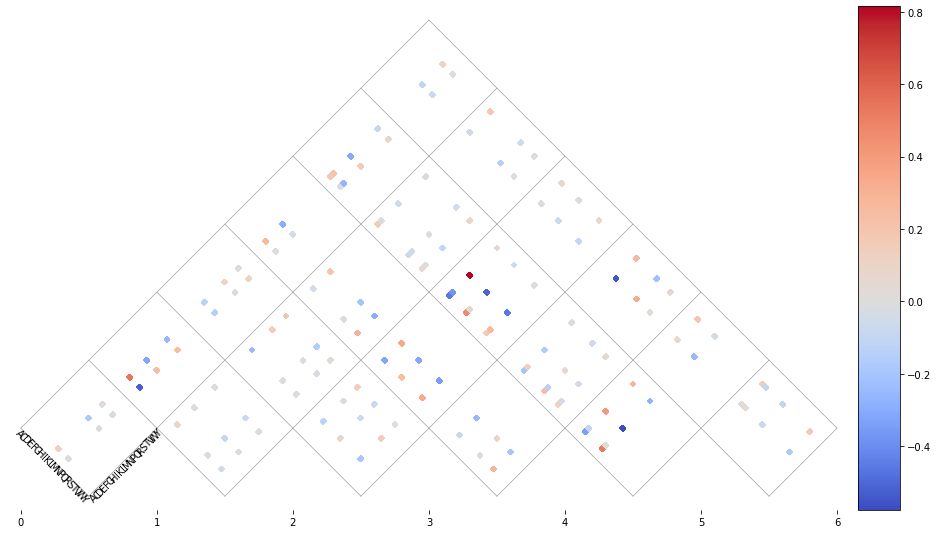

In [6]:
#Find the best regularization for additive fitness(learning rate)
lr_ls=[1e-3,5e-3,1e-2,3e-2,5e-2]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for lr in lr_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19') 
        model = Train_model(train_set,test_set,0.8,lr,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = lr_ls.index(lr)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0164 sec.
Epoch 1/1000
35/35 [==============================] - 0s 6ms/step - loss: 39.5111 - I_var: 0.1576 - val_loss: 17.0310 - val_I_var: 0.7340
Epoch 2/1000
35/35 [==============================] - 0s 3ms/step - loss: 17.8652 - I_var: 0.6386 - val_loss: 18.6509 - val_I_var: 0.5458
Epoch 3/1000
35/35 [==============================] - 0s 3ms/step - loss: 18.7016 - I_var: 0.5230 - val_loss: 17.1426 - val_I_var: 0.5919
Epoch 4/1000
35/35 [==============================] - 0s 3ms/step - loss: 16.7708 - I_var: 0.6897 - val_loss: 18.0152 - val_I_var: 0.6772
Epoch 5/1000
35/35 [==============================] - 0s 3ms/step - loss: 16.8895 - I_var: 0.7539 - val_loss: 14.8561 - val_I_var: 0.8464
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 18.6001 - I_var: 0.6387 - val_loss: 17.0722 - val_I_var: 0.7285
Epoch 7/1000
35/35 [==============================] - 0s

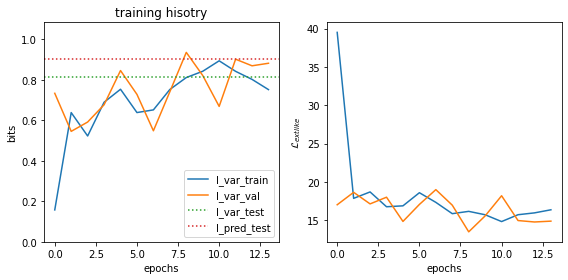

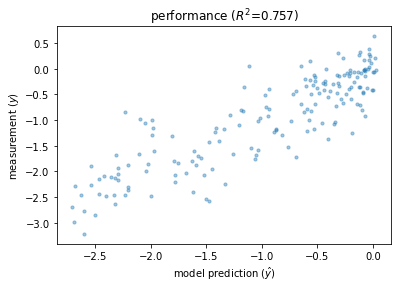

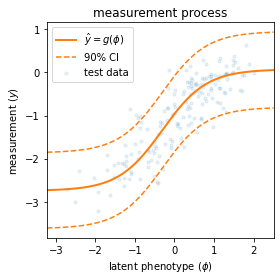

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0196 sec.
Epoch 1/1000
35/35 [==============================] - 0s 7ms/step - loss: 38.6266 - I_var: 0.2591 - val_loss: 17.9979 - val_I_var: 0.6067
Epoch 2/1000
35/35 [==============================] - 0s 3ms/step - loss: 17.1757 - I_var: 0.6905 - val_loss: 20.0139 - val_I_var: 0.3743
Epoch 3/1000
35/35 [==============================] - 0s 3ms/step - loss: 17.6579 - I_var: 0.7100 - val_loss: 14.6567 - val_I_var: 0.8281
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 17.0485 - I_var: 0.7064 - val_loss: 16.9201 - val_I_var: 0.7049
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 16.6759 - I_var: 0.6993 - val_loss: 15.9891 - val_I_var: 0.7817
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 15.6703 - I_var: 0.7900 - val_loss: 14.2221 - val_I_var: 0.8801
Epoch 7/1000
35/35 [==============================] - 0s

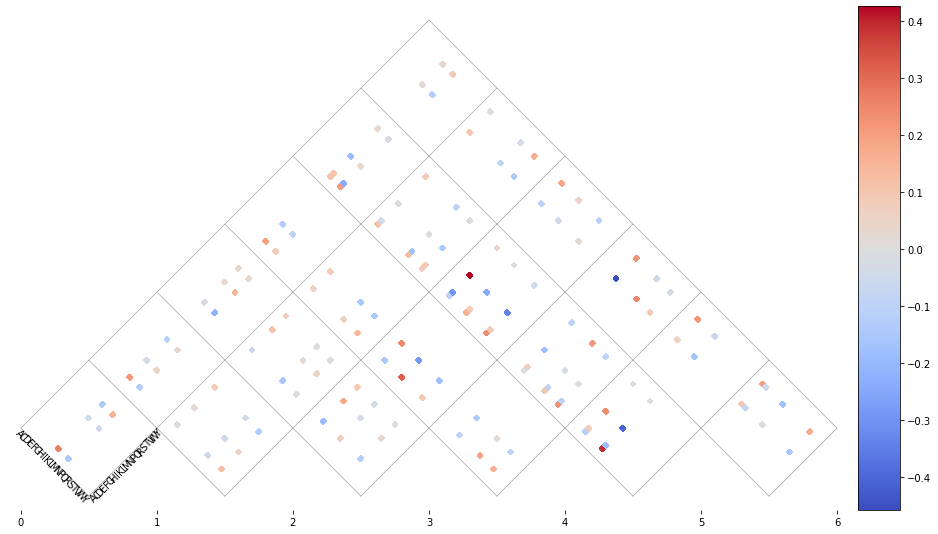

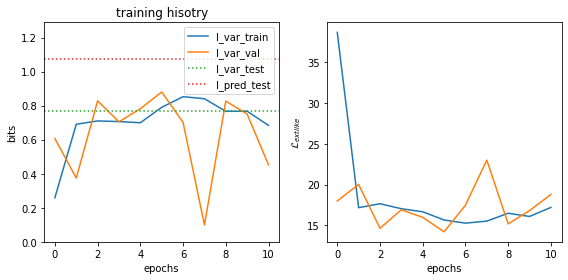

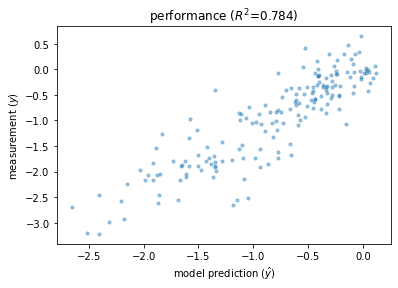

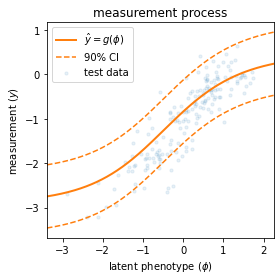

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0168 sec.
Epoch 1/1000
18/18 [==============================] - 0s 11ms/step - loss: 78.1261 - I_var: -0.0823 - val_loss: 45.7847 - val_I_var: 0.1549
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 39.1298 - I_var: 0.4755 - val_loss: 29.4020 - val_I_var: 0.8708
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 31.4142 - I_var: 0.7303 - val_loss: 36.3138 - val_I_var: 0.5661
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 34.2405 - I_var: 0.5840 - val_loss: 32.1425 - val_I_var: 0.6550
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 29.0948 - I_var: 0.8208 - val_loss: 27.0073 - val_I_var: 0.8767
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 26.3196 - I_var: 0.8656 - val_loss: 24.0729 - val_I_var: 1.0836
Epoch 7/1000
18/18 [==============================] - 

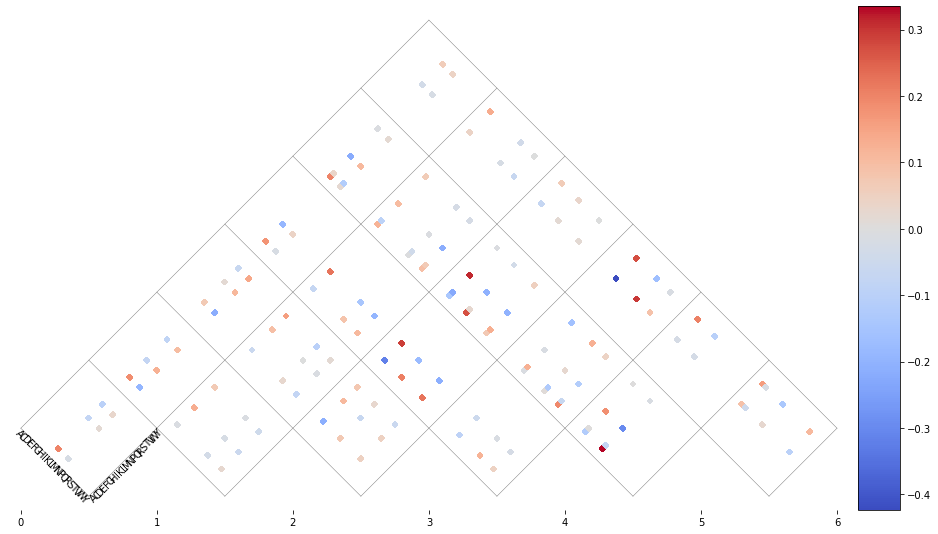

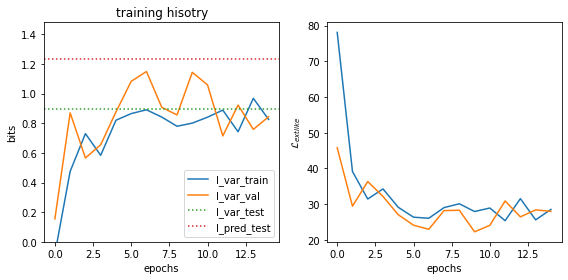

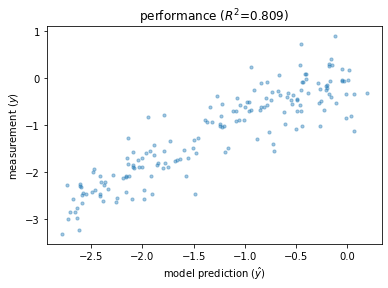

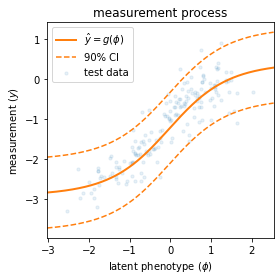

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0155 sec.
Epoch 1/1000
18/18 [==============================] - 0s 10ms/step - loss: 76.2348 - I_var: 0.0737 - val_loss: 39.9930 - val_I_var: 0.4813
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 32.1955 - I_var: 0.7775 - val_loss: 47.8687 - val_I_var: -0.0617
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 36.4702 - I_var: 0.5639 - val_loss: 33.6886 - val_I_var: 0.6679
Epoch 4/1000
18/18 [==============================] - 0s 4ms/step - loss: 29.0616 - I_var: 0.8707 - val_loss: 23.7539 - val_I_var: 1.0064
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 26.2298 - I_var: 0.8994 - val_loss: 25.1831 - val_I_var: 0.9671
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 24.5987 - I_var: 1.0530 - val_loss: 23.4637 - val_I_var: 1.0436
Epoch 7/1000
18/18 [==============================] - 

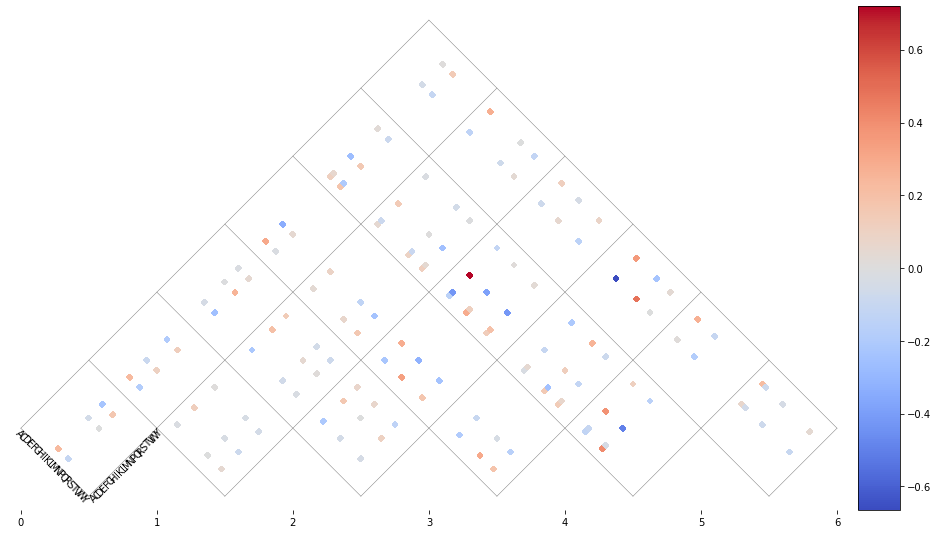

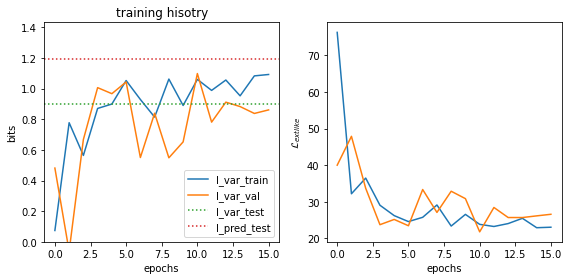

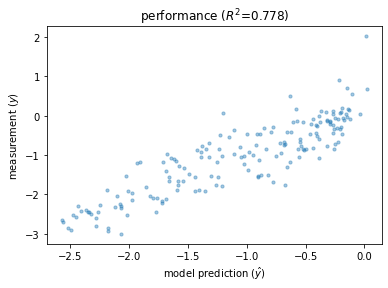

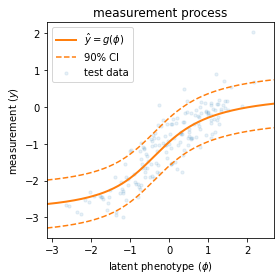

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0152 sec.
Epoch 1/1000
12/12 [==============================] - 0s 14ms/step - loss: 103.3010 - I_var: 0.2219 - val_loss: 84.9443 - val_I_var: -0.0784
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 56.0228 - I_var: 0.6162 - val_loss: 50.1181 - val_I_var: 0.6357
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 40.3669 - I_var: 0.9283 - val_loss: 45.5930 - val_I_var: 0.7327
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 43.7593 - I_var: 0.8350 - val_loss: 43.2970 - val_I_var: 0.8138
Epoch 5/1000
12/12 [==============================] - 0s 5ms/step - loss: 36.4613 - I_var: 1.0495 - val_loss: 29.4315 - val_I_var: 1.2158
Epoch 6/1000
12/12 [==============================] - 0s 5ms/step - loss: 30.8422 - I_var: 1.1039 - val_loss: 43.6598 - val_I_var: 0.7355
Epoch 7/1000
12/12 [==============================] -

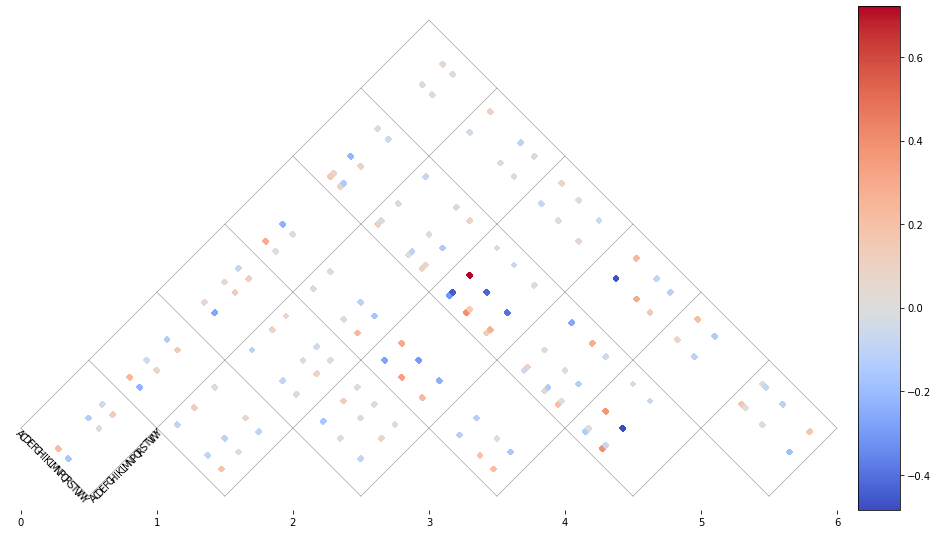

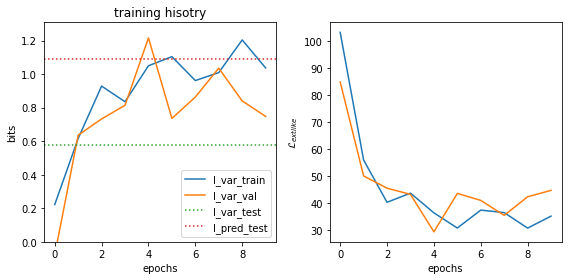

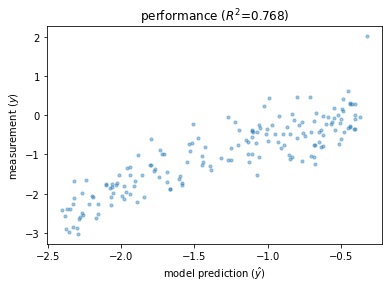

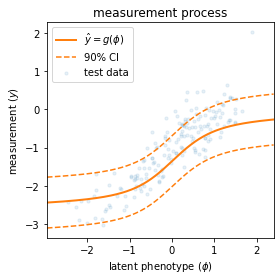

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0154 sec.
Epoch 1/1000
12/12 [==============================] - 0s 14ms/step - loss: 114.7676 - I_var: -0.1407 - val_loss: 82.2210 - val_I_var: -0.0821
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 68.1290 - I_var: 0.2088 - val_loss: 51.4093 - val_I_var: 0.5891
Epoch 3/1000
12/12 [==============================] - 0s 4ms/step - loss: 42.5136 - I_var: 0.8235 - val_loss: 46.4291 - val_I_var: 0.7219
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 34.4695 - I_var: 1.1319 - val_loss: 43.1331 - val_I_var: 0.8744
Epoch 5/1000
12/12 [==============================] - 0s 4ms/step - loss: 34.2533 - I_var: 1.1717 - val_loss: 46.3586 - val_I_var: 0.7908
Epoch 6/1000
12/12 [==============================] - 0s 4ms/step - loss: 31.6121 - I_var: 1.2377 - val_loss: 47.9384 - val_I_var: 0.7258
Epoch 7/1000
12/12 [==============================] 

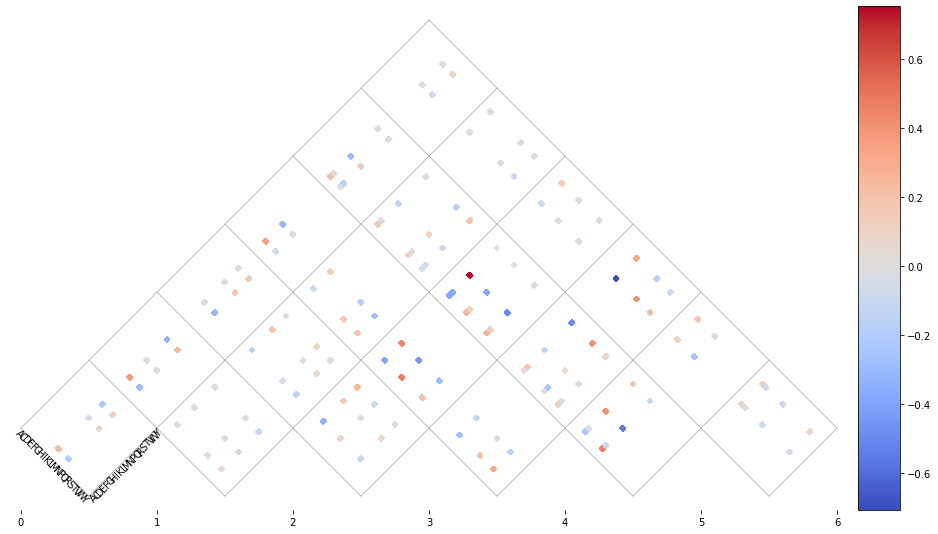

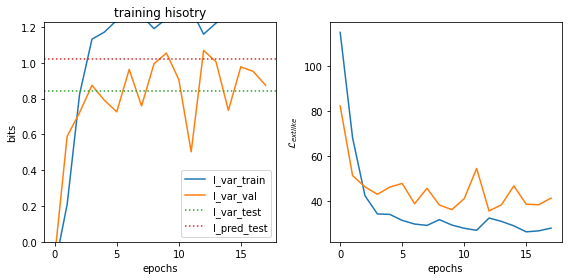

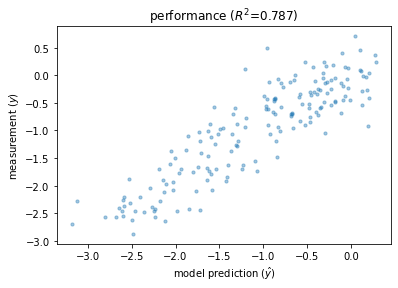

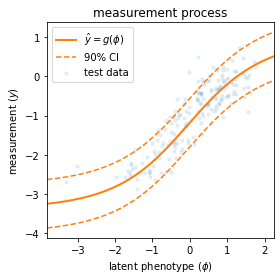

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.015 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 141.2720 - I_var: 0.0038 - val_loss: 90.4708 - val_I_var: 0.2912
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 81.8480 - I_var: 0.4844 - val_loss: 65.3495 - val_I_var: 0.5208
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 52.4063 - I_var: 0.9770 - val_loss: 55.6601 - val_I_var: 0.8347
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 43.5505 - I_var: 1.1524 - val_loss: 46.9041 - val_I_var: 0.9235
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 39.4012 - I_var: 1.2104 - val_loss: 42.1242 - val_I_var: 1.2241
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 42.5457 - I_var: 1.1544 - val_loss: 44.2590 - val_I_var: 0.9838
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - l

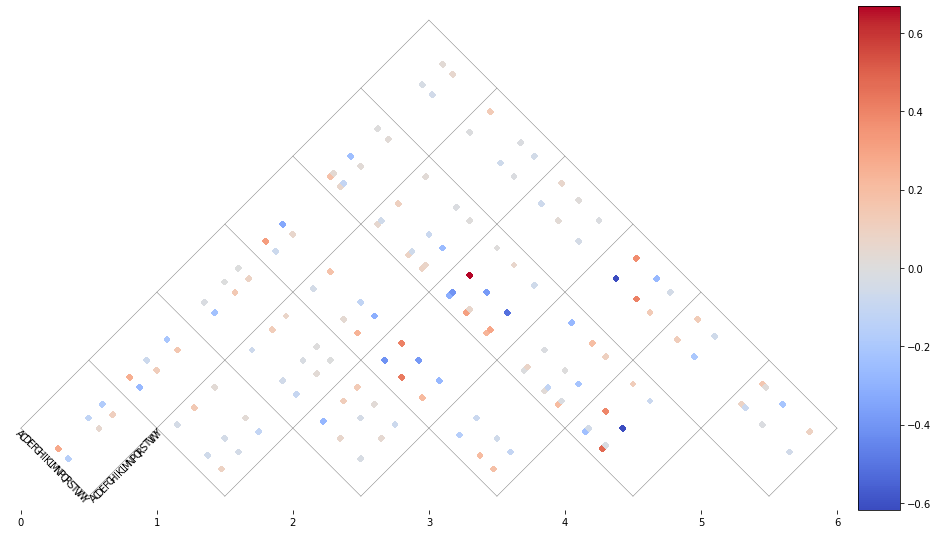

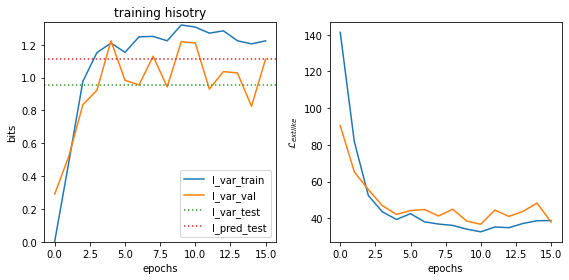

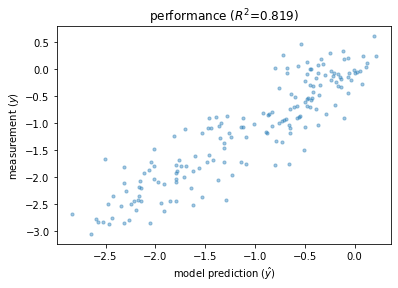

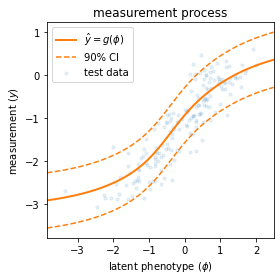

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0156 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 143.5094 - I_var: -0.1118 - val_loss: 98.4688 - val_I_var: 0.0412
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 82.4679 - I_var: 0.4260 - val_loss: 58.2264 - val_I_var: 0.8276
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 52.7935 - I_var: 0.9063 - val_loss: 42.5627 - val_I_var: 0.9934
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 43.7531 - I_var: 1.1075 - val_loss: 81.7099 - val_I_var: 0.2117
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 66.8555 - I_var: 0.5911 - val_loss: 38.4204 - val_I_var: 1.1883
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 53.4639 - I_var: 0.8649 - val_loss: 51.7393 - val_I_var: 0.9927
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step -

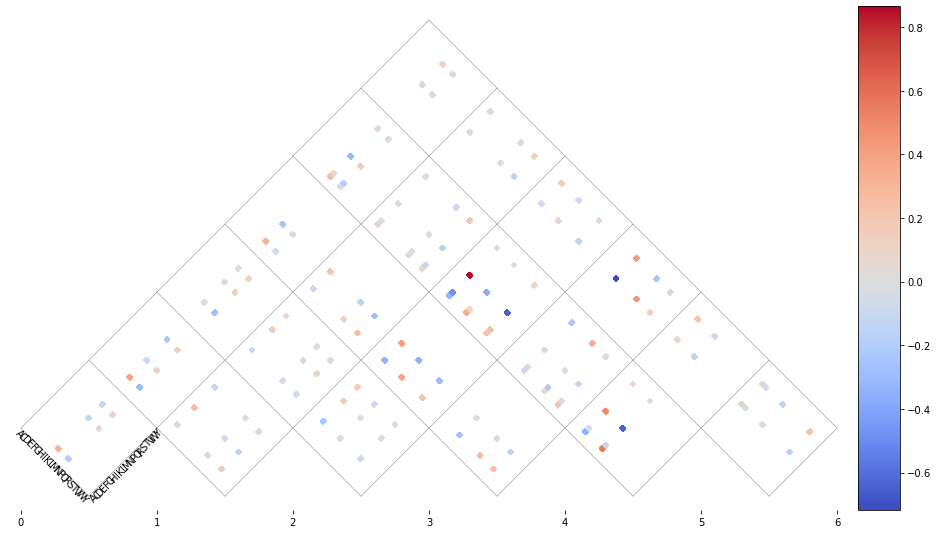

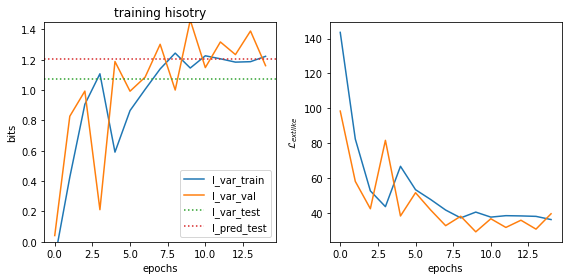

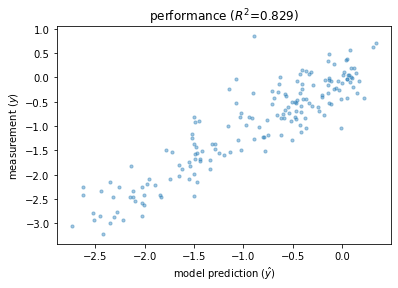

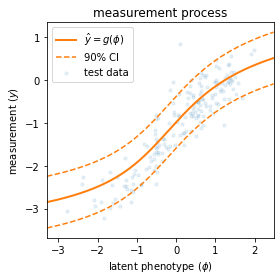

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0155 sec.
Epoch 1/1000
5/5 [==============================] - 0s 34ms/step - loss: 260.0409 - I_var: -0.1090 - val_loss: 183.2430 - val_I_var: 0.1223
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 171.7104 - I_var: 0.2430 - val_loss: 160.7587 - val_I_var: 0.3627
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 144.5116 - I_var: 0.5348 - val_loss: 126.9337 - val_I_var: 0.7553
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 115.2662 - I_var: 0.7878 - val_loss: 106.9090 - val_I_var: 0.6891
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 95.8541 - I_var: 1.0294 - val_loss: 82.7545 - val_I_var: 1.0104
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 76.6598 - I_var: 1.1827 - val_loss: 61.0643 - val_I_var: 1.4435
Epoch 7/1000
5/5 [==============================] - 0

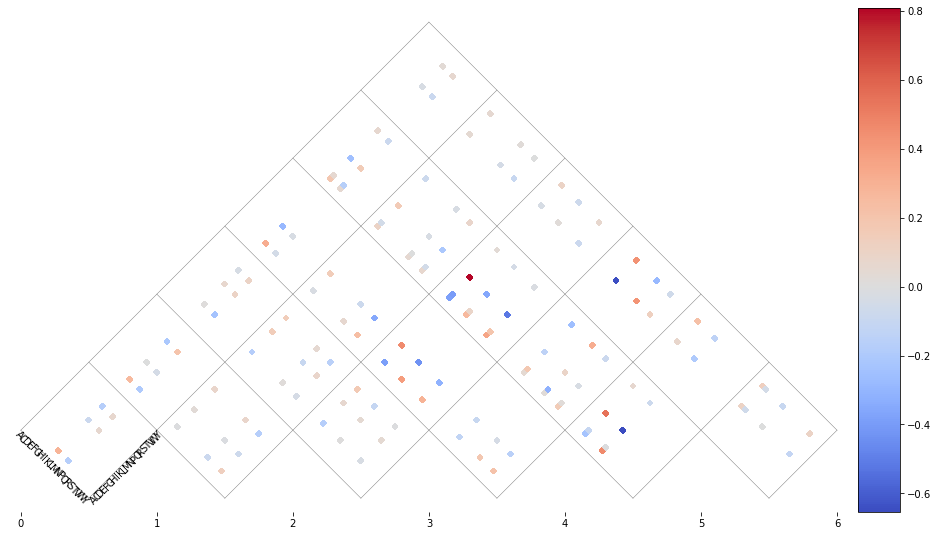

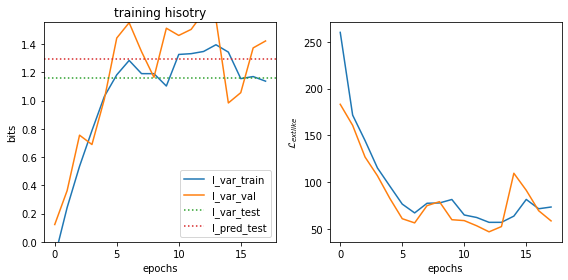

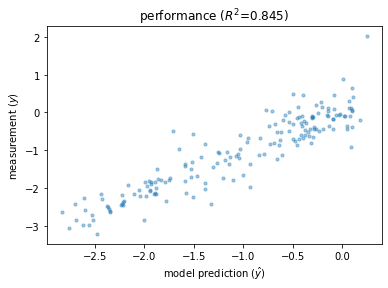

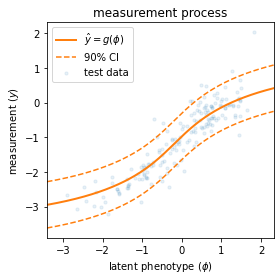

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0159 sec.
Epoch 1/1000
5/5 [==============================] - 0s 34ms/step - loss: 250.5872 - I_var: -0.0294 - val_loss: 167.2485 - val_I_var: 0.1741
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 168.9453 - I_var: 0.2426 - val_loss: 148.1466 - val_I_var: 0.4403
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 144.3507 - I_var: 0.5126 - val_loss: 130.7881 - val_I_var: 0.5434
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 129.0230 - I_var: 0.5884 - val_loss: 103.2271 - val_I_var: 1.0136
Epoch 5/1000
5/5 [==============================] - 0s 11ms/step - loss: 96.2406 - I_var: 0.9503 - val_loss: 79.4436 - val_I_var: 1.1223
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 72.8217 - I_var: 1.1670 - val_loss: 67.5858 - val_I_var: 1.4246
Epoch 7/1000
5/5 [==============================] - 0

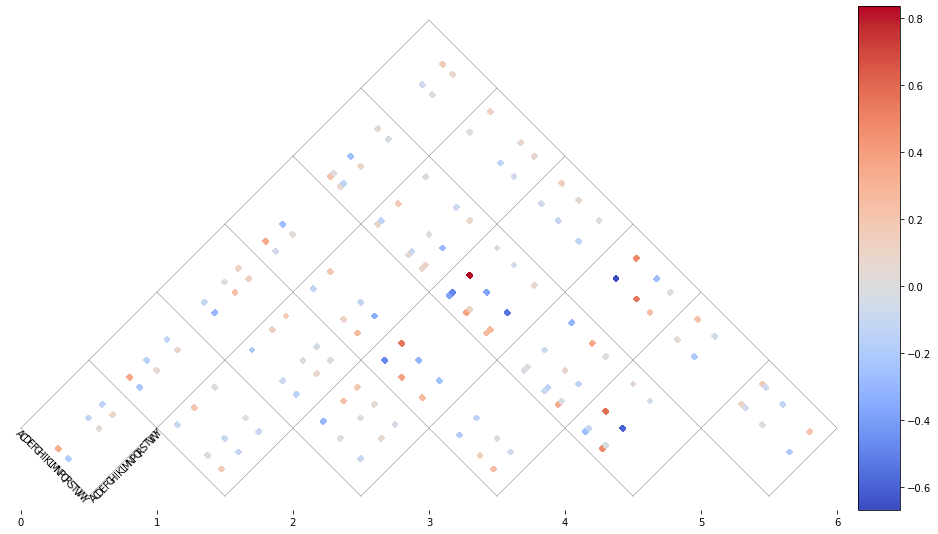

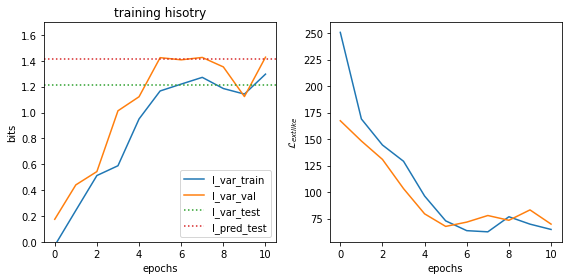

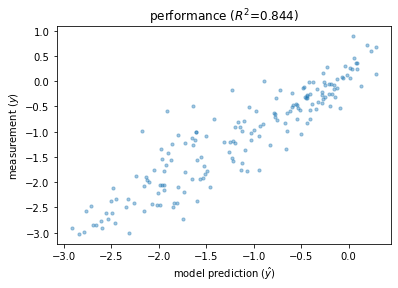

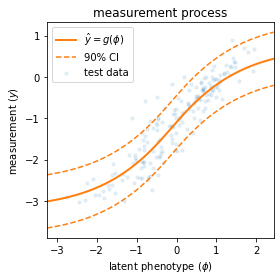

[[0.95447189]
 [0.9506187 ]
 [0.94410239]
 [0.8881494 ]
 [0.67084146]]
[[0.84001706]
 [0.90522555]
 [0.93618184]
 [0.95194429]
 [0.95122125]]


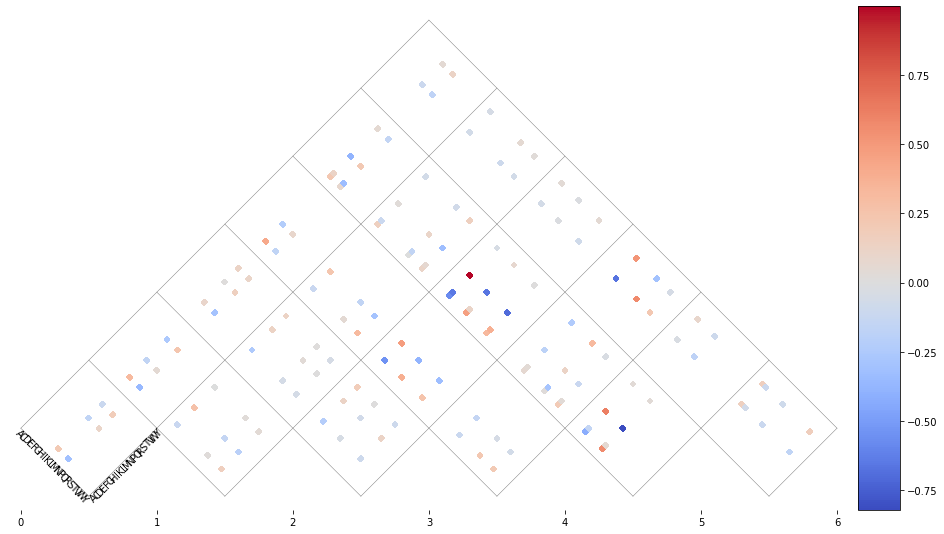

In [8]:
#Find the best regularization for additive fitness(batch_size)
bs_ls=[16,32,48,64,128]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for bs in bs_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Vic11') 
        model = Train_model(train_set,test_set,0.8,0.05,bs)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
        fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
        mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
        data = theta['theta_lclc']
        epi_map=array2df(data)
        epi_map=epi_map.dropna(thresh=3)
        epi_df = df2epimap(epi_map)
        
        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
    R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = bs_ls.index(bs)
    add[index,0]=R
    epi[index,0]=R_epi
print(add)   
print(epi)

We now define a MAVE-NN model with pairwise G-P map and a Gaussian noise model. 

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0      707  NNESKKS   HK68  6.375305       1  0.018204  0.109588  0.063896   
1      188  NDRGKTS   HK68  6.374207       1  0.029351  0.048562  0.038956   
2      772  KNKGKTL   HK68  6.776550       3  0.019257  0.014317  0.016787   
3      710  KSRNKKL   HK68  7.067078       4  0.040903  0.086621  0.063762   
4      848  NSENEKS   HK68  6.087708      -1  0.069035  0.154373  0.111704   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686     55  KDESKTL   HK68  6.222717       0  0.044427  0.063992  0.054209   
687    638  KSRSEKS   HK68  6.554993       2  0.023715  0.051238  0.037476   
688    662  KSKGEEL   HK68  6.224182       0  0.061383  0.067500  0.064441   
689    314  KSKNEDL   HK68  6.222717       0  0.024591  0.083983  0.054287   
690    723  NDEGETL   HK68  5.846130      -3  0.007152  0.025755  0.016453   

            y    set  
0   -2.750498  train  
1   -3.245311  tr

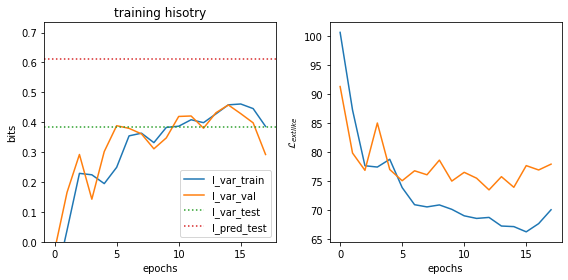

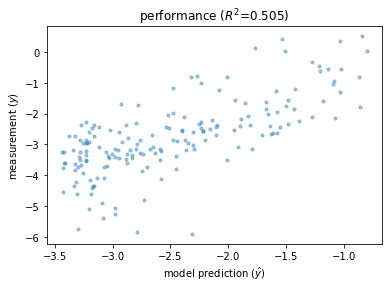

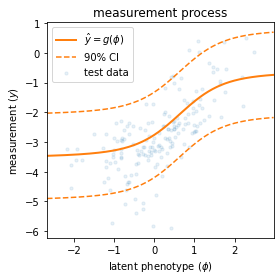

Model saved to these files:
	../result/HK68_epi.pickle
	../result/HK68_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.081668
1    1.0  2.0   K   N -0.328533
2    1.0  2.0   K   S  0.009662
3    1.0  2.0   N   D  0.201639
4    1.0  2.0   N   N  0.054113
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.151311
149  6.0  7.0   K   L -0.152512
150  6.0  7.0   K   S -0.103566
151  6.0  7.0   T   L -0.118993
152  6.0  7.0   T   S  0.101132

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.593514
1   328  N  0.350432
2   329  D  0.184039
3   329  N -0.153291
4   329  S -0.225173
5   344  E -0.184203
6   344  K -0.035719
7   344  R -0.177462
8   367  G -0.276893
9   367  N -0.049775
10  367  S  0.011694
11  368  E  0.145801
12  368  K -0.005980
13  369  D  0.121286
14  369  E  0.257100
15  369  K -0.283460
16  369  T  0.149919
17  370  L -0.250806
18  370  S -0.153319


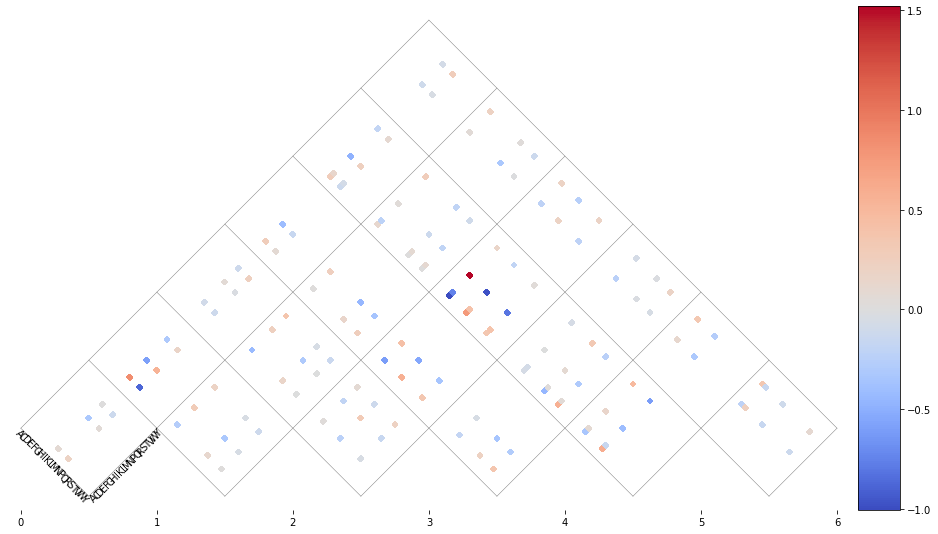

In [9]:
##Loading HK68 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68')
print(train_set)
model = Train_model(train_set,test_set,0.1,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK68_epi')
#model = mavenn.load('../result/HK68_epi')
## Plot additive 
## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK68_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HK68_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     1229  KSENKKL   Bk79  7.728577       2  0.146677  0.145866  0.146271   
1     1022  KSKGKKL   Bk79  8.126282       4  0.186873  0.031092  0.108982   
2     1265  KSEGEES   Bk79  6.513977      -2  0.255496  0.180364  0.217930   
3     1702  KSKGEDS   Bk79  7.040100       0  0.152916  0.316736  0.234826   
4      986  KNRNKTL   Bk79  7.961609       3  0.028756  0.083173  0.055964   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   1212  NSEGKTL   Bk79  7.040100       0  0.071672  0.061159  0.066416   
687   1641  NSRGKTL   Bk79  7.731384       2  0.013310  0.122875  0.068093   
688   1634  KDKNEDL   Bk79  6.741272      -1  3.151628  3.976497  3.564062   
689    939  NSKSKES   Bk79  7.404846       1  0.080138  0.202591  0.141365   
690   1237  KSRNKES   Bk79  7.730042       2  0.010915  0.019264  0.015090   

            y    set  
0   -1.922291  train  
1   -2.216569  tr

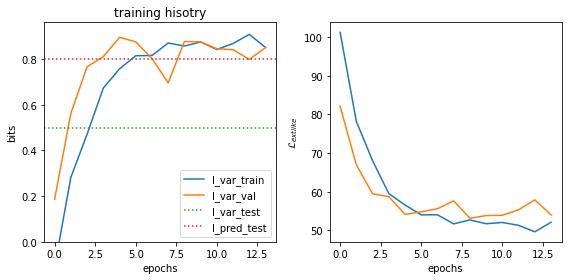

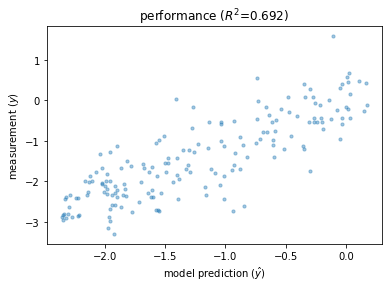

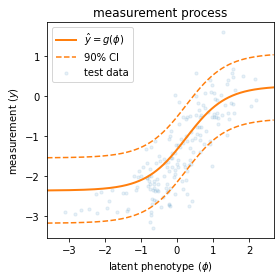

Model saved to these files:
	../result/Bk79_epi.pickle
	../result/Bk79_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.248821
1    1.0  2.0   K   N -0.320399
2    1.0  2.0   K   S -0.398926
3    1.0  2.0   N   D  0.143475
4    1.0  2.0   N   N -0.062251
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.022818
149  6.0  7.0   K   L  0.101849
150  6.0  7.0   K   S -0.485749
151  6.0  7.0   T   L -0.035883
152  6.0  7.0   T   S -0.097844

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.490856
1   328  N  0.148445
2   329  D -0.075062
3   329  N -0.329914
4   329  S -0.620934
5   344  E -0.073335
6   344  K -0.177454
7   344  R -0.081480
8   367  G -0.470005
9   367  N -0.130385
10  367  S  0.107223
11  368  E  0.001183
12  368  K -0.215588
13  369  D  0.608438
14  369  E  0.269173
15  369  K -0.088005
16  369  T -0.289652
17  370  L -0.064699
18  370  S  0.352970


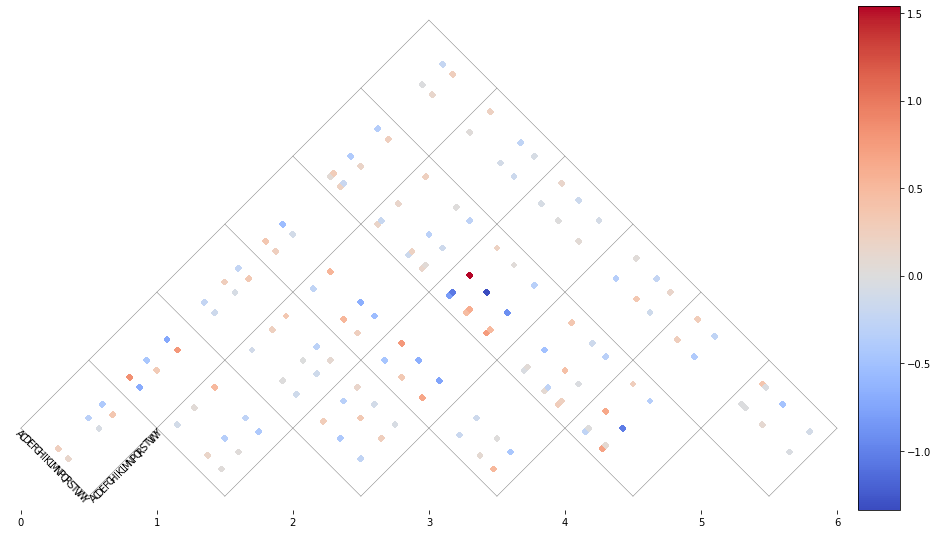

In [10]:
##Loading Bk79 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bk79')
print(train_set)
model = Train_model(train_set,test_set,0.1,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bk79_epi')
#model = mavenn.load('../result/Bk79_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bk79_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Bk79_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     2463  NSKSEKS  Bei89  7.417786       1  0.217356  0.117935  0.167646   
1     2169  KDRGETL  Bei89  7.066467       0  0.359625  0.182533  0.271079   
2     2072  NSESKDS  Bei89  6.777405      -1  1.368789  0.760288  1.064538   
3     2461  NNRGKDS  Bei89  7.418396       1  0.192259  0.178495  0.185377   
4     2433  KSRSEEL  Bei89  7.066956       0  1.096812  1.243373  1.170093   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   2573  KNKGKTS  Bei89  7.961853       3  0.086038  0.097271  0.091654   
687   2430  KSEGEDS  Bei89  6.556580      -2  1.430472  0.722482  1.076477   
688   2106  KSENETL  Bei89  6.778015      -1  2.617391  2.643739  2.630565   
689   2049  KSRSEES  Bei89  7.066956       0  0.737836  0.893774  0.815805   
690   1752  NSESETS  Bei89  6.555969      -2  2.246750  2.258795  2.252773   

            y    set  
0   -1.785903  train  
1   -1.305345  tr

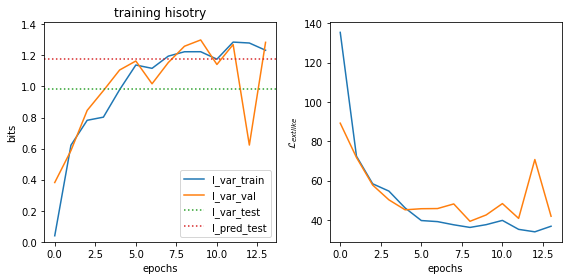

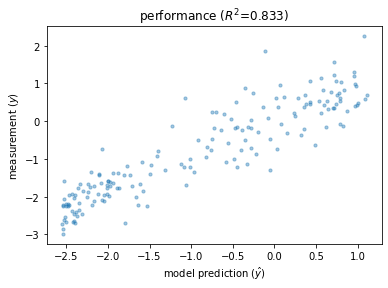

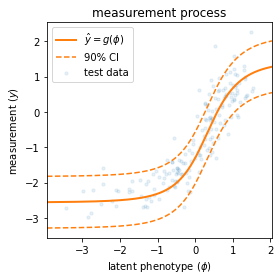

Model saved to these files:
	../result/Bei89_epi.pickle
	../result/Bei89_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.058237
1    1.0  2.0   K   N -0.046421
2    1.0  2.0   K   S -0.119693
3    1.0  2.0   N   D  0.010193
4    1.0  2.0   N   N  0.075174
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.109594
149  6.0  7.0   K   L -0.180074
150  6.0  7.0   K   S -0.298863
151  6.0  7.0   T   L -0.076187
152  6.0  7.0   T   S  0.077662

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.105215
1   328  N  0.075750
2   329  D  0.059349
3   329  N  0.024072
4   329  S -0.195493
5   344  E  0.294083
6   344  K -0.124200
7   344  R -0.147045
8   367  G -0.292944
9   367  N  0.104115
10  367  S  0.095714
11  368  E  0.382842
12  368  K -0.473038
13  369  D  0.283321
14  369  E  0.191059
15  369  K -0.491811
16  369  T -0.002515
17  370  L -0.030313
18  370  S -0.077688


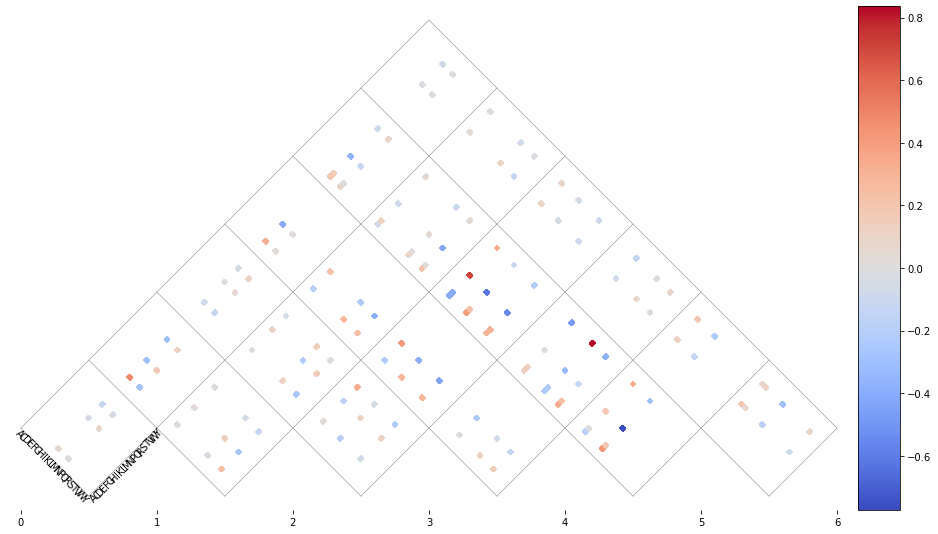

In [11]:
##Loading Bei89 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Bei89_epi')
#model = mavenn.load('../result/Bei89_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Bei89_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Bei89_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     2596  NNRNEKS  Mos99  6.377380       1  0.361026  0.461285  0.411155   
1     2758  NDRNKKS  Mos99  6.555603       2  0.152195  0.254494  0.203345   
2     3152  NDKGKDS  Mos99  6.224060       0  0.795200  0.765180  0.780190   
3     3008  NNRGKES  Mos99  6.377380       1  0.238298  0.277507  0.257902   
4     2862  KDRSKEL  Mos99  6.378113       1  0.783838  0.611785  0.697812   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   2740  KSEGKTS  Mos99  6.377380       1  0.342169  0.370881  0.356525   
687   2858  NDENEKS  Mos99  5.967834      -2  1.279452  1.359527  1.319490   
688   2792  NNESKKL  Mos99  6.377380       1  0.263415  0.160887  0.212151   
689   2804  KDRSKKS  Mos99  6.777527       3  0.077311  0.080628  0.078969   
690   3125  NSKNKTL  Mos99  6.554993       2  0.301706  0.202619  0.252163   

            y    set  
0   -0.888784  train  
1   -1.592853  tr

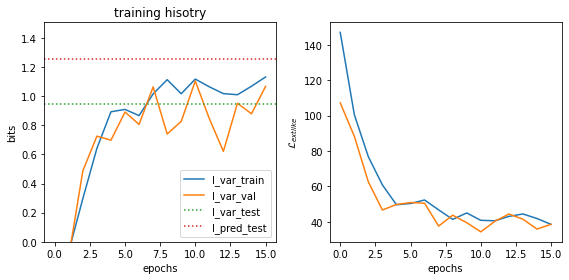

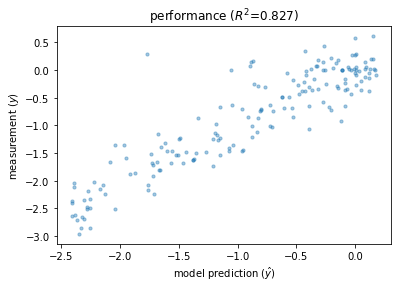

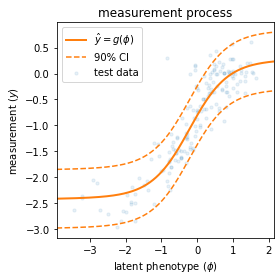

Model saved to these files:
	../result/Mos99_epi.pickle
	../result/Mos99_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.109294
1    1.0  2.0   K   N  0.023788
2    1.0  2.0   K   S -0.187239
3    1.0  2.0   N   D  0.041164
4    1.0  2.0   N   N -0.117140
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S  0.109876
149  6.0  7.0   K   L -0.072201
150  6.0  7.0   K   S -0.234074
151  6.0  7.0   T   L  0.057272
152  6.0  7.0   T   S  0.037276

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K -0.083732
1   328  N  0.019597
2   329  D  0.191612
3   329  N -0.148485
4   329  S -0.066843
5   344  E  0.075680
6   344  K -0.062459
7   344  R -0.070521
8   367  G -0.072185
9   367  N -0.028987
10  367  S  0.061891
11  368  E  0.312647
12  368  K -0.337554
13  369  D  0.138839
14  369  E  0.123774
15  369  K -0.351681
16  369  T  0.064274
17  370  L  0.096676
18  370  S -0.023751


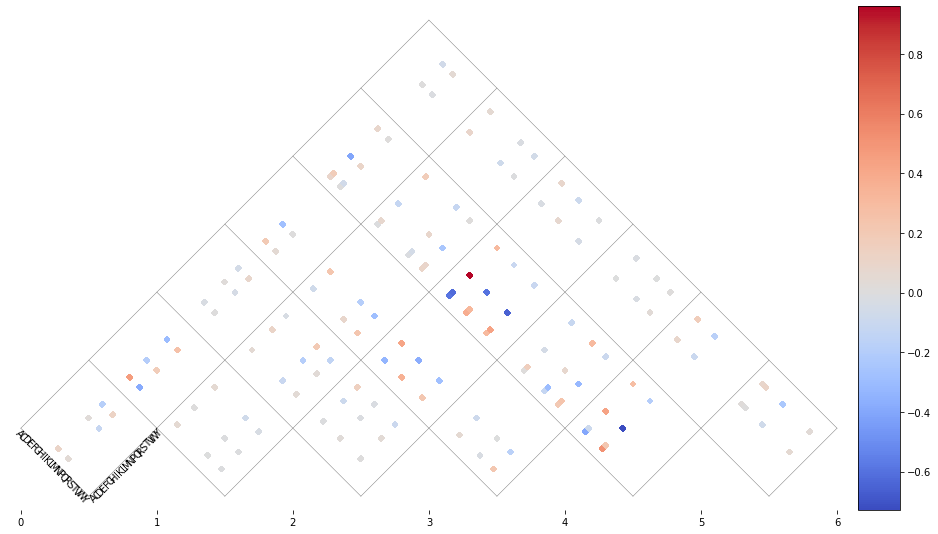

In [13]:
##Loading Mos99 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Mos99')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Mos99_epi')
#model = mavenn.load('../result/Mos99_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Mos99_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Mos99_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     3469  KDESEES  Vic11  6.095276      -3  0.778803  0.818360  0.798582   
1     3959  NSESEES  Vic11  6.094177      -3  0.307496  0.373720  0.340608   
2     3541  NDRNEES  Vic11  6.228088      -2  0.409712  0.298225  0.353969   
3     3928  NSKNEDL  Vic11  6.378601      -1  1.242906  1.304011  1.273458   
4     3692  KNEGKES  Vic11  6.558655       0  0.229267  0.173646  0.201457   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   3742  NSENKKS  Vic11  6.779846       1  0.409995  0.328676  0.369335   
687   4040  KDRGETS  Vic11  6.557800       0  0.746060  0.530562  0.638311   
688   4199  NSRGKDL  Vic11  6.779358       1  0.091812  0.149765  0.120788   
689   3947  KDRNEKL  Vic11  6.780334       1  0.770565  0.525914  0.648240   
690   3614  KSKGKKL  Vic11  7.746155       4  0.120669  0.083474  0.102071   

            y    set  
0   -0.224918  train  
1   -1.077022  tr

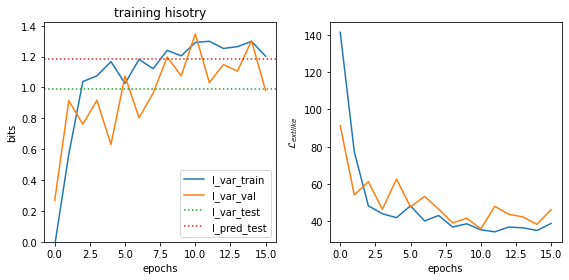

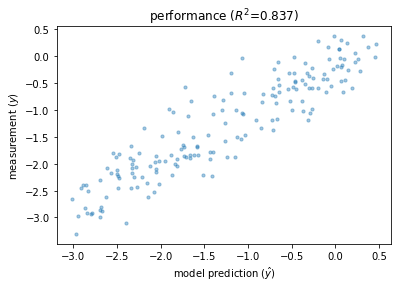

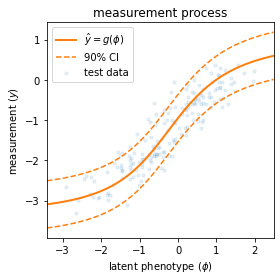

Model saved to these files:
	../result/Vic11_epi.pickle
	../result/Vic11_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.354267
1    1.0  2.0   K   N -0.141884
2    1.0  2.0   K   S -0.168446
3    1.0  2.0   N   D -0.199271
4    1.0  2.0   N   N  0.107921
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.075515
149  6.0  7.0   K   L  0.014108
150  6.0  7.0   K   S -0.097389
151  6.0  7.0   T   L -0.153627
152  6.0  7.0   T   S  0.167030

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.010343
1   328  N -0.069256
2   329  D  0.225213
3   329  N -0.074065
4   329  S -0.100441
5   344  E  0.087266
6   344  K -0.026163
7   344  R -0.011700
8   367  G -0.246238
9   367  N  0.180985
10  367  S  0.085726
11  368  E  0.260001
12  368  K -0.272410
13  369  D  0.235295
14  369  E -0.125115
15  369  K -0.094290
16  369  T -0.000492
17  370  L -0.121602
18  370  S  0.133505


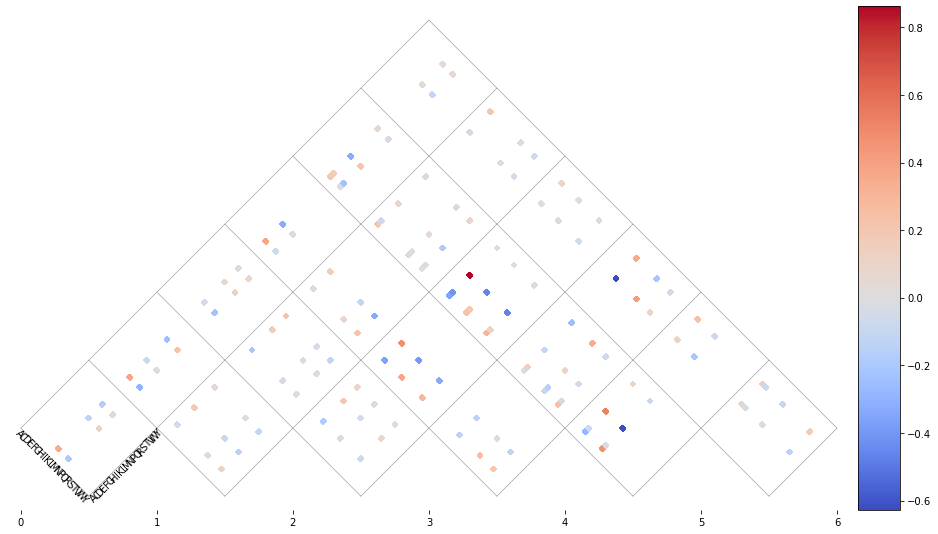

In [14]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Vic11')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/Vic11_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/Vic11_add.csv')
print(add_df)

<ipython-input-2-db44c8c27736>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     4322  KSRGEES   HK19  6.424011       0  0.788602  0.733663  0.761132   
1     4723  KDRNEDL   HK19  6.275696      -1  2.268154  1.538617  1.903386   
2     5028  KNEGETS   HK19  6.276184      -1  0.806427  0.530401  0.668414   
3     4655  NDENETL   HK19  6.025818      -3  0.412392  0.760578  0.586485   
4     4557  NDESKDL   HK19  6.144348      -2  0.503740  0.753957  0.628848   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   4722  KDKGETL   HK19  6.422913       0  0.369596  0.303265  0.336430   
687   4524  KDESETL   HK19  6.145935      -2  2.232801  1.212440  1.722620   
688   4437  NNKGEES   HK19  6.276184      -1  1.007173  0.552971  0.780072   
689   4535  KNKSKKS   HK19  7.438293       4  0.097029  0.199599  0.148314   
690   4936  KDESKKL   HK19  6.596985       1  0.338920  0.670033  0.504476   

            y    set  
0   -0.272948  train  
1    0.643634  tr

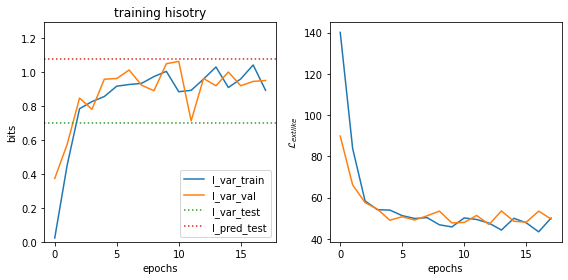

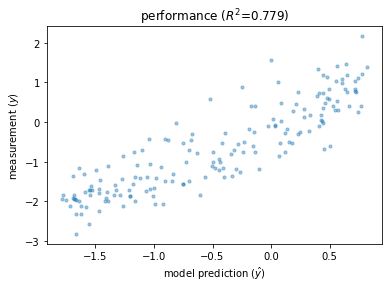

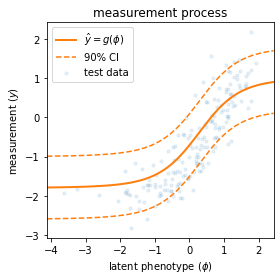

Model saved to these files:
	../result/HK19_epi.pickle
	../result/HK19_epi.h5
      L1   L2 AA1 AA2       EPI
0    1.0  2.0   K   D  0.234750
1    1.0  2.0   K   N -0.209382
2    1.0  2.0   K   S -0.049512
3    1.0  2.0   N   D -0.016802
4    1.0  2.0   N   N -0.018840
..   ...  ...  ..  ..       ...
148  6.0  7.0   E   S -0.069028
149  6.0  7.0   K   L -0.093887
150  6.0  7.0   K   S -0.081706
151  6.0  7.0   T   L -0.052266
152  6.0  7.0   T   S  0.117775

[153 rows x 5 columns]
    pos aa   add_fit
0   328  K  0.016784
1   328  N  0.052261
2   329  D  0.301100
3   329  N -0.336368
4   329  S -0.103757
5   344  E  0.026525
6   344  K -0.026111
7   344  R -0.035747
8   367  G -0.311260
9   367  N  0.121553
10  367  S  0.230237
11  368  E  0.245340
12  368  K -0.287133
13  369  D  0.172331
14  369  E -0.050226
15  369  K -0.227740
16  369  T  0.052950
17  370  L -0.202329
18  370  S  0.082809


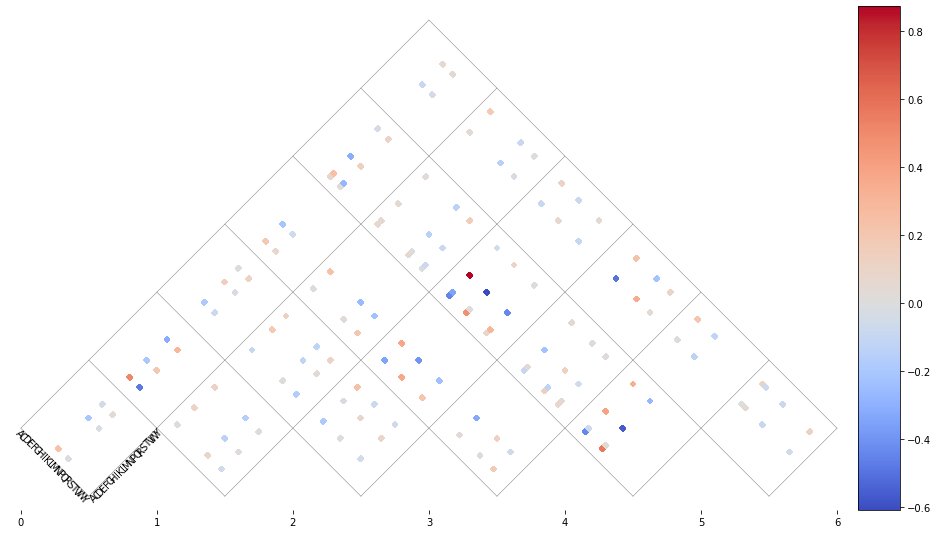

In [20]:
##Loading HK19 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
model.save('../result/HK19_epi')
#model = mavenn.load('../result/HK19_epi')

## Plot epistasis
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[16, 10])          
mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
data = theta['theta_lclc']
theta_lc=theta['theta_lc']
epi_map=array2df(data)
epi_map=epi_map.dropna(thresh=3)
epi_df = df2epimap(epi_map)
epi_df.to_csv('../result/HK19_epi.csv')
print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/HK19_add.csv')
print(add_df)